In [1]:
# Packages to import
import random
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import seaborn as sns
import matplotlib as mpl
from BF_checkers import *
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import factorial, comb
from sympy import simplify_logic
from scipy.stats import spearmanr
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
#This code generates the BFs at each node that satisfy the attractor constraints (this works for upto 6 input functions)

# The inputs to this code are:
# 1. an attractor file (contains all nodes and attractors): attractor.tsv
# 2. edgelist (derived from the network structure, with interaction signs): edgelist.tsv

# Note: The BF to a node has a truth table like this:
#--------------------|
# B | A | C |D(A,B,C)|
#-----------|--------|
# 0   0   0 |  0     |
# 0   0   1 |  0     |
# 0   1   0 |  0     |
# 0   1   1 |  0     |
# 1   0   0 |  0     |
# 1   0   1 |  0     |
# 1   1   0 |  0     |
# 1   1   1 |  1     |
#--------------------|

# The order of the variables B, A, C from Left to Right is the same as the
#order of inputs to a node from top to bottom in the edgefile

def model_data(fpath, dataset):
    '''
    path: a path to a file where all the data is present regarding the
    edges and attractor files
    returns information about the network and desired attractors
        -node_num: a dictionary where each gene is associated with an
        integer
        -inedges:  a dictionary where each gene is associated with its
        regulatory inputs
        -signs: a list of all the signs, in the order of the nodes
        -attr_as_matrix: the attractor specified as a matrix
    '''
    edges = pd.read_csv(fpath + fr'/edges_{dataset}.txt', sep = '\t')
    bio_attrs = pd.read_csv(fpath + fr'/attractors_{dataset}.tsv', sep = '\t')
    node_num = {bio_attrs.gene[i]:i for i in range(len(bio_attrs))}
    in_edges = dict()
    signs = dict()
    for node in bio_attrs.gene:
        inter = edges.loc[edges["to"] == node, ["fro", "sign"]]
        signs[node_num[node]] = ''.join(list(inter.sign))
        in_edges[node_num[node]] = [node_num[ele] for ele in inter['fro']]
        if in_edges[node_num[node]] == []:
            in_edges[node_num[node]] = [node_num[node]]
            signs[node_num[node]] = 'a'
            print (f'Node {node} does not have any inputs. Self loop assigned!')
    attr_as_matrix = bio_attrs.drop('gene', axis = 1).to_numpy()    
    return node_num, in_edges, attr_as_matrix, signs
    
def attr_constr_funcs(fpath, dataset):
    '''
    path: a path to a file where all the data is present regarding the
    edges and attractor files
    filename: name of the particular model under consideration
    returns a list of BFs in the order in 'node_num' which satisfy the
    attractor constraints
    NOTE: those rows of the truth table where a function output is replaced
    multiple times have to be excluded from the constraint
    '''
    attr_constr_BFs = dict()
    M = model_data(fpath, dataset)
    node_num, in_edges, attr_as_matrix = M[0], M[1], M[2]
    for node in node_num:
        i = node_num[node]
        x = np.array(attr_as_matrix[i], str)
        attr_constr_rows = np.zeros(len(attr_as_matrix.T), str)
        for in_edge in in_edges[i]:
            attr_constr_rows = np.char.add(attr_constr_rows, np.array(attr_as_matrix[in_edge], str))
        rows = np.array([int(ele,2) for ele in attr_constr_rows])
        rows, x = check_conflicting_constraints(rows, x) #Check for conflicting constraints for rows at the node under consideration
        tt = np.array (2**len(in_edges[i])*['x'])
        tt[rows] = x
        attr_constr_BFs[node_num[node]] = ''.join(tt)
    return attr_constr_BFs

def check_conflicting_constraints (rows, rows_output):
    '''
    rows: all the truth table rows which are constrainted by the attractor
    rows_output:  all the outputs of the rows of the truth table which
    are constrainted by the attractor
    returns rows and the row outputs with no conflicting constraints
    '''
    D, remove_indices = {}, []
    for element in set(rows):
        D[element] = [index for index, ele in enumerate(rows) if ele == element]
    for element in D:
        if len(set(rows_output[D[element]])) > 1:
            remove_indices += D[element]
            print ('There exists a conflict at row :', element)
    for index in sorted(remove_indices, reverse=True):
        rows = np.delete(rows, index)
        rows_output = np.delete(rows_output, index)
    return rows, rows_output

class constrainBF:
    '''
    #functionality
    given a BF constrained with the fixed point attractors, this returns all the scEUFs, scRoFs or scNCFs
    that satisfy those constraints at each node
    '''
    def __init__(self, BF, sign):
        '''
        #arguments
        BF: Boolean function as a string of bits '11xx'; x can be 0/1
        sign: string of 'a' and 'i'; 'ai'
        '''
        self.BF = BF
        self.sign = sign
        self.constr_rows = [ind for ind, bit in enumerate(self.BF) if bit != 'x']
        self.fixed_bits = list(itemgetter(*self.constr_rows)(self.BF))

    def with_scEUF (self):
        '''
        constrains BFs with sign-conforming Effective and Unate functions
        '''
        k = len(self.sign)
        uf_act_df = pd.read_csv(fr'../data/computational/UF_perms/all_UFs_k{k}.tsv', sep = '\t')
        euf_act_df = uf_act_df[uf_act_df['IEF']== False]
        inh_edges = [k-index for index, s in enumerate(self.sign) if s == 'i']                
        possible_scEUFs = []
        
        if 'x' not in self.BF:
            if check_if(k, self.BF).conforms_to_edge_signs(self.sign):
                possible_scEUFs += [int(self.BF,2)]
            else:
                print ('Given BF cannot be sc-EUF')
        else:
            for func in euf_act_df['all_UFs']:
                func = bf(k, str(func).zfill(2**k)).swap_rows(inh_edges)
                if list(itemgetter(*self.constr_rows)(func)) == self.fixed_bits:
                    possible_scEUFs += [int(func, 2)]
        return possible_scEUFs

    def with_scNCF (self):
        '''
        constrains BFs with sign-conforming nested canalyzing functions
        '''
        k = len(self.sign)
        possible_scNCFs = []
        inh_edges = [k-index for index, s in enumerate(self.sign) if s == 'i']

        if 'x' not in self.BF:
            if check_if(k, self.BF).conforms_to_edge_signs(self.sign):
                if check_if(k, self.BF).is_NCF():
                    possible_scNCFs += [int(self.BF, 2)]
            else:
                print ('Given BF cannot be scNCF')

        else:
            with open (fr'../data/computational/NCF_perms/all_perms_NCF{k}.txt', 'r') as file:
                for func in file:
                    func = bf(k, bin(int(func.strip('\n')))[2:].zfill(2**k)).swap_rows(inh_edges)
                    if list(itemgetter(*self.constr_rows)(func)) == self.fixed_bits:
                        possible_scNCFs += [int(func, 2)]
        
        return possible_scNCFs

    def with_scRoF (self):
        '''
        constrains BFs with sign-conforming read-once functions
        '''
        k = len(self.sign)
        possible_scrofs = []
        inh_edges = [k-index for index, s in enumerate(self.sign) if s == 'i']

        if 'x' not in self.BF:
            if check_if(k, self.BF).conforms_to_edge_signs(self.sign):
                with open (fr'../data/computational/RoF_perms/all_perms_RoF{k}.txt', 'r') as file:
                    for func in file:
                        func = bf(k, bin(int(func.strip('\n')))[2:].zfill(2**k)).swap_rows(inh_edges)
                        if self.BF == func:
                            possible_scrofs += [int(self.BF, 2)]
            else:
                print ('Given BF cannot be scRoF')
            
        else:            
            with open (fr'../data/computational/RoF_perms/all_perms_RoF{k}.txt', 'r') as file:
                for func in file:
                    func = bf(k, bin(int(func.strip('\n')))[2:].zfill(2**k)).swap_rows(inh_edges)
                    if list(itemgetter(*self.constr_rows)(func)) == self.fixed_bits:
                        possible_scrofs += [int(func, 2)]
            
        return possible_scrofs

def constrain_all_nodes (BF_list, signs, func_type_dict={}, all_type='scNCF'):
    '''
    BF_list: is a dictionary with key as nodes and values as BFs that satisfy attractor
    constraints
    signs: the signs of the inedges for each of the nodes
    func_type_dict: node
    return a dictionary with all the nodes and the BFs satisfying
    attractor and functional constraints
    '''
    constr_dict = {}

    if all_type != None:
        for node in BF_list:
            func_type_dict[node] = all_type
            
    for node in BF_list:
        if func_type_dict[node] == 'scEUF':
            constr_dict[node] = constrainBF(BF_list[node], signs[node]).with_scEUF()

        elif func_type_dict[node] == 'scNCF':
            constr_dict[node] = constrainBF(BF_list[node], signs[node]).with_scNCF()

        elif func_type_dict[node] =='scRoF':
            constr_dict[node] = constrainBF(BF_list[node], signs[node]).with_scRoF()

    return constr_dict

In [3]:
model_name = 'buylla_RSCN_2010A'
path = fr'../data/{model_name}'
filename = fr'{model_name}'
node_num, inedges, attrs, signs = model_data(path, filename)
print("Node to number association:\n", node_num)
print("\nIncoming edges to each node:\n", inedges)
print ("\nThe regulatory signs at each node:\n", signs)
BF_list = attr_constr_funcs(path, filename)
constr_dict_scNCF = constrain_all_nodes (BF_list, signs, func_type_dict={}, all_type='scNCF')
print ('\nBoolean functions at each node (encoded as integers):\n', constr_dict_scNCF)

Node to number association:
 {'PLT': 0, 'AUXIN': 1, 'ARF': 2, 'AUXIAA': 3, 'SHR': 4, 'SCR': 5, 'JKD': 6, 'MGP': 7, 'WOX5': 8}

Incoming edges to each node:
 {0: [2], 1: [1], 2: [3], 3: [1], 4: [4], 5: [4, 6, 7, 5], 6: [4, 5], 7: [4, 8, 5], 8: [4, 2, 8, 5, 7]}

The regulatory signs at each node:
 {0: 'a', 1: 'a', 2: 'i', 3: 'i', 4: 'a', 5: 'aaia', 6: 'aa', 7: 'aia', 8: 'aaaai'}

Boolean functions at each node (encoded as integers):
 {0: [1], 1: [1], 2: [2], 3: [2], 4: [1], 5: [1029, 69, 13, 1109, 1293, 20319, 79, 1349, 23903, 93, 1039, 3085, 17477, 3343, 3919, 17749, 21853], 6: [1], 7: [4], 8: [2, 42, 11, 131082, 35, 522, 131586, 131075, 546, 131106, 515, 196643, 197123, 131843, 2228770, 131087, 2228266, 139810, 33686026, 33686050, 8746, 133642, 47, 2602, 33686019, 655371, 8739, 196619, 2228259, 527, 655402, 655882, 803, 2571, 779, 2831, 34212362, 35791394, 720911, 33751811, 983567, 168430122, 50529035, 3887, 983087, 134927, 572662307, 168430091, 50529059, 572662314, 34540047, 573188650

In [4]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in 
Boolean Gene Regulatory Networks
'''
class BN:
    '''
    Class to obtain fixed points and sizes of basins of attraction of fixed points 
    '''
    def __init__(self, inedges, BF_list, bio_fp):
        '''
        inedges: dictionary where keys are genes and associated values are a list of inputs (encoded as integers)
        BF_list: BF at each gene encoded as an integer
        bio_fp: list of biological fixed points encoded as integers
        '''
        self.inedges = inedges
        self.BF_list = BF_list
        self.bio_fp = bio_fp
        self.n = len(self.inedges)
    
    def IntsToBitsFast (ints, size):
        '''
        return an array of bits of length 'size' for the set of integers ints such that the MSB is at column 0
        source: https://stackoverflow.com/questions/
        ints: numpy array of integers
        size: required size of the array of bits
        '''
        return (((ints[:,None] & (1 << np.arange(size, dtype = 'int64'))[::-1])) > 0).astype(int)

    def IntsToBitsFast_large (int_num, size):
        '''
        returns an array of bits of length 'size' such that the MSB is at column 0
        source: https://stackoverflow.com/questions/
        int_num : integer
        size: required size of the array of bits
        '''
        b = [int_num >> i & 1 for i in range(int_num.bit_length() - 1,-1,-1)]
        if len(b) != size:
            b = (size-len(b))*[0] + b
        return np.array([b])

    def BitsToIntsFast(bits):
        '''
        returns an array of integers
        bits: a matrix of bits whose rows represent the integer of interest
        from: https://stackoverflow.com/questions/41069825/convert-binary-01-numpy-to-integer-or-binary-string
        '''
        m,n = bits.shape # number of columns is needed, not bits.size
        a = 2**np.arange(n)[::-1]  # -1 reverses array of powers of 2 of same length as bits
        return bits @ a  # this matmult is the key line of code

    def STV (self):
        '''
        returns the state transition vector
        The index of each element of this vector is the previous state as an integer
        '''
        x = BN.IntsToBitsFast (np.arange(2**self.n), self.n)
        new_mat = np.zeros([2**self.n, self.n], dtype = int)
        for node in self.inedges:
            q = self.inedges[node]
            ind = BN.BitsToIntsFast(x[:,q])
            f = BN.IntsToBitsFast_large(self.BF_list[node], 2**len(q))
            new_mat[:,node] = f[:,ind]
        stv = BN.BitsToIntsFast(new_mat)
        return stv

    def fxd_pts (self, stv):
        '''
        returns the fixed point of the BN
        stv: state transition vector
        '''
        return np.where(np.arange(len(stv)) == stv)[0]

    def basin_fp (self, fp, stv):
        '''
        returns the states in the basin of the fixed point 'fp'
        fp: fixed point as an integer
        stv: state transition vector
        '''
        stg = nx.DiGraph()
        stg.add_edges_from (list(zip(np.arange(len(stv)), stv)))
        return list(nx.ancestors(stg, fp)) + [fp]

    def basin_sizes_fps (self, stv):
        '''
        returns a dictionary where keys are attractors and values are the associated sizes
        stv: state transition vector
        '''
        stg = nx.DiGraph()
        stg.add_edges_from (list(zip(np.arange(len(stv)), stv)))
        boa = {}
        for fp in self.bio_fp:
            boa[fp] = len(nx.ancestors(stg, fp)) + 1
        D = {k: v for k, v in sorted(boa.items(), key=lambda item:item[1])}
        return D

In [5]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in 
Boolean Gene Regulatory Networks
'''

class RS(BN):
    '''
    Gives the quantities to compute the relative stability of fixed points
    '''
    def __init__(self, inedges, BF_list, bio_fp):
        super().__init__(inedges, BF_list, bio_fp)
    
    def T_star (self, p, stv):
        '''
        returns the state transition matrix where each element Tij is the probability
        of transition from state j to state i
        p: probability of flipping a gene
        stv: the state transition vector
        '''
        hw = {}
        for i in range(1, 2**self.n):
            hw[i] = (p**i) * ((1-p)**(self.n-i))
        P = np.zeros((2**self.n, 2**self.n))
        for i in range(0,2**self.n -1):
            for j in range (i+1, 2**self.n):
                ham_ij = np.binary_repr(np.bitwise_xor(i,j)).count('1')
                P[i][j] = hw[ham_ij]
        P += P.T
        for i in range(0,len(stv)):
            P[stv[i], i] += (1-p)**self.n
        return P
    
    def SSP (self, T_star):
        '''
        returns the steady state probability vector 
        T_star: state transition matrix with noise
        '''
        n = 0
        prob_0 = np.zeros(2**self.n)
        prob_0[np.random.randint(2**self.n)] = 1.0
        while (True):
            prob_1 = T_star @ prob_0
            if np.array_equal (np.round(prob_1, 8), np.round(prob_0, 8)):
                break
            else:
                prob_0 = prob_1
        return prob_0

    def MFPT_ana (self, T_star, ssp):
        '''
        returns the MFPT matrix where each entry M_ij is the MFPT from state j to state i 
        T_star: state transition matrix with noise
        ssp: steady state probability vector
        '''
        I = np.identity(2**self.n)
        W = np.tile(ssp, (2**self.n,1)).T
        Z_ij = np.linalg.inv(I- T_star + W)
        Z_ii = np.tile(np.diag(Z_ij), (2**self.n, 1)).T
        M_ij = ((Z_ii - Z_ij).T / ssp).T
        return M_ij

    def MFPT_num_2_states (u, v, p, trajectories, stv):
        '''
        stochastic approach to compute MFPT between 2 fixed points
        returns the mean time taken to first hit state 'v' when starting from state 'u'
        v: beginning fixed point
        u: terminal fixed point
        p: noise (between 0 and 1)
        trajectories: number of independent trajectories beginning from state v
        stv: state transition vector
        '''
        T = []
        t = 0
        new = np.array(trajectories*[v])
        n = int(np.log2(len(stv)))
        while len(new) != 0:
            end = np.array(len(new)*[u])
            noise = np.array(np.random.rand(len(new), n) < p, dtype=int)
            noise_int = BN.BitsToIntsFast(noise)
            eta = np.array(noise_int > 0, dtype=int)
            eta_comp = eta ^ np.array(len(eta)*[1])
            new_temp = eta*(new ^ noise_int) + eta_comp*(stv[new])
            new = np.extract(new_temp!=end, new_temp)
            t+=1
            T+=(len(new_temp) - len(new))*[t]
        return {'mfpt': sum(T)/trajectories,  'sterr' : np.std(np.array(T))/np.sqrt(trajectories)}

    def MFPT_num (fps, p, trajectories, stv):
        '''
        stochastic approach to compute MFPT matrix between all pairs of biological fixed points
        returns a matrix where an element M_uv represents the time taken to 
        transition from fixed point 'v' to fixed point 'u' via a stochastic approach
        fps: a list of all the fixed points as integers
        p: noise (between 0 and 1)
        trajectories: number of independent trajectories beginning from a fixed point
        '''
        mfpt_matrix = np.zeros([len(fps), len(fps)])
        st_err = np.zeros([len(fps), len(fps)])
        state_mapping = {fps[i]:i for i in range(len(fps))}
        for u in fps:
            for v in fps:
                if u != v:
                    x = RS.MFPT_num_2_states(u, v, p, trajectories, stv)
                    mfpt_matrix[state_mapping[u], state_mapping[v]] = x['mfpt']
                    st_err[state_mapping[u], state_mapping[v]] = x['sterr']
                else:
                    mfpt_matrix[state_mapping[u], state_mapping[v]] = 0
        return mfpt_matrix, st_err
    
    def btr_2_states (T_star, u, v, boa):
        '''
        returns the basin transition rate from the state v to the state u each belonging to 2 different attractors
        T_star: state transtion matrix with noise
        v: beginning fixed point
        u: terminal fixed point
        boa: a dictionary whose keys are biologically relevant fixed points and values are a list of the states in the basin of the fixed points
        '''
        U, V = np.array(boa[u]), np.array(boa[v])
        return np.sum(T_star[U[:,None], V])/len(V)

    def BTR (T_star, boa):
        '''
        T_star: state transtion matrix with noise
        boa: a dictionary whose keys are biologically relevant fixed points and values are a list of the states in the basin of the fixed points
        '''
        btr_matrix = np.zeros([len(boa), len(boa)])
        fps = list(boa.keys())
        state_mapping = {fps[i]:i for i in range(len(fps))}
        for u in boa:
            for v in boa:
                btr_matrix[state_mapping[u], state_mapping[v]] = RS.btr_2_states(T_star, u, v, boa)
        return btr_matrix

    def O_i_j (self, i, J):
        '''
        O_i_j: fraction of one degree neighbours of i in the basin of attraction of j
        i: attractor 'i' as an integer
        J : basin of attraction of J as a list
        '''
        h_neibs = np.array(self.n*[i]) ^ 2**np.arange(self.n)
        oneib = 0
        for ele in h_neibs:
            if ele in J:
                oneib += 1
        return oneib/self.n

    def stability_index (self, A, boa):
        '''
        A: the attractor whose stability index is being calculated
        boa: basin of attraction of all the attractors
        '''
        t1, t2 = 0, 0
        for i in boa:
            t1 += RS.O_i_j (self, i, boa[A])
            if i != A:
                t2 += RS.O_i_j (self, A, boa[i])
        return t1 - t2

    def RS_BOA (u, v, bsz):
        '''
        returns the relative stabiity of U and V using the basin of attraction
        bsz: dictionary of the sizes of the basins for each of the fixed points

        if RS_BOA (u, v, bsz) > 0 then u is relatively more stable compared to v
        '''
        return np.log(bsz[u]/bsz[v])

    def RS_SSP (u, v, ssp):
        '''
        returns the relative stabiity of u and v using the steady state probability 
        ssp: steady state probability vector
        V: beginning fixed point
        U: terminal fixed point

        if RS_SSP (u, v, ssp) > 0 then u is relatively more stable compared to v
        '''
        return np.log(ssp[u]/ssp[v])

    def RS_MFPT (u, v, mfpt):
        '''
        returns the relative stabiity of u and v using the mean first passage time
        mfpt: mean first passage time matrix
        V: beginning fixed point
        U: terminal fixed point

        if RS_MFPT (u, v, mfpt) > 0 then u is relatively more stable compared to v
        '''
        return 1/ mfpt[u,v] - 1/mfpt[v,u]

    def RS_BTR (u, v, T_star, boa):
        '''
        returns the relative stabiity of u and v using the basin transition rate
        T_star: state transition matrix with noise
        V: beginning fixed point
        U: terminal fixed point
        boa: a dictionary whose keys are biologically relevant fixed points and values are a list of the states in the basin of the fixed points

        if RS_BTR (u, v, T_star, boa) > 0 then u is relatively more stable compared to v
        '''
        return np.log(RS.btr_2_states(T_star, u, v, boa)/RS.btr_2_states(T_star, v, u, boa))
    
    def RS_SIND (self, u, v, boa):
        '''
        return the relative stabiity of u and v using the stability index
        V: beginning fixed point
        U: terminal fixed point
        boa: a dictionary whose keys are biologically relevant fixed points and values are a list of the states in the basin of the fixed points

        if RS_SIND (u, v, boa) > 0 then u is relatively more stable compared to v
        '''
        return RS.stability_index (self, u, boa) - RS.stability_index (self, v, boa)

In [6]:
#------------------------------------------------------------------------------------------------------------------
# Defining a Boolean network
#------------------------------------------------------------------------------------------------------------------
model = 'buylla_RSCN_2010A'
constr = 'exact'
BF_type = 'scNCF'
noise = 0.01

with open ('../data/'+ model + '/node_num.pkl', 'rb') as file:
    node_num = pkl.load(file)

with open ('../data/'+ model + '/inedges.pkl', 'rb') as file:
    inedges = pkl.load(file)

with open ('../data/' + model + '/' + constr +  '/' + BF_type + '/' + constr + '_' + BF_type + '.pkl', 'rb') as file:
    BF_lists = pkl.load(file)

attrs = pd.read_csv('../data/' + model + '/attractors_' + model + '.tsv', sep = '\t')
attrs_new = attrs.drop(columns= ['gene'], axis = 1)
bio_fp = BN.BitsToIntsFast(np.array(attrs_new).T)
attr_num = {attrs_new.columns[i]:bio_fp[i] for i in range(len(bio_fp))}
BF_list = BF_lists[73]
print ('Integer encoding of the nodes:\n', node_num)
print ('\nIncoming edges to each node:\n', inedges)
print ('\nNumber of models satifying' + constr + ' and ' + constr + ' fixed points for ' + model + ':\n',  len(BF_lists))
print ('\nAttractors encoded as integers: \n', attr_num)


Integer encoding of the nodes:
 {'PLT': 0, 'AUXIN': 1, 'ARF': 2, 'AUXIAA': 3, 'SHR': 4, 'SCR': 5, 'JKD': 6, 'MGP': 7, 'WOX5': 8}

Incoming edges to each node:
 {0: [2], 1: [1], 2: [3], 3: [1], 4: [4], 5: [4, 6, 7, 5], 6: [4, 5], 7: [4, 8, 5], 8: [4, 2, 8, 5, 7]}

Number of models satifyingexact and exact fixed points for buylla_RSCN_2010A:
 170

Attractors encoded as integers: 
 {'QC': 477, 'VI': 464, 'CEI': 478, 'CepI': 448}


In [7]:
#------------------------------------------------------------------------------------------------------------------
#Example of how to compute the relative stability of a pair of fixed points 'QC' and 'VI' using the different
#measures of relative stability
#------------------------------------------------------------------------------------------------------------------

model_class = RS(inedges, BF_list, bio_fp)
stv = model_class.STV()
fps = model_class.fxd_pts(stv)
bsz = model_class.basin_sizes_fps(stv)
boa = {fp:model_class.basin_fp(fp, stv) for fp in fps}
print ('The fixed points are: ', fps)
print ('The basin sizes for each of the fixed points are :', bsz)

noise = 0.01
T_star = model_class.T_star(noise, stv)
ssp = model_class.SSP(T_star)
mfpt = model_class.MFPT_ana(T_star, ssp)
btr = RS.BTR(T_star, boa)
sind = model_class.stability_index(fps[2], boa)

u_name, v_name = 'QC', 'VI'
u, v = attr_num[u_name], attr_num[v_name]
print ("RS_BOA (QC, VI): ", RS.RS_BOA (u, v, bsz))
print ("RS_SSP (QC, VI): ", RS.RS_SSP (u, v, ssp))
print ("RS_MFPT (QC, VI): ", RS.RS_MFPT (u, v, mfpt))
print ("RS_BTR (QC, VI): ", RS.RS_BTR (u, v, T_star, boa))
print ("RS_SIND (QC, VI): ", model_class.RS_SIND (u, v, boa))

The fixed points are:  [448 464 477 478]
The basin sizes for each of the fixed points are : {478: 16, 477: 48, 464: 192, 448: 256}
RS_BOA (QC, VI):  -1.3862943611198906
RS_SSP (QC, VI):  -4.358127330667452
RS_MFPT (QC, VI):  -0.013895571100228703
RS_BTR (QC, VI):  -1.3862943611198906
RS_SIND (QC, VI):  -0.7777777777777779


In [8]:
#------------------------------------------------------------------------------------------------------------------
#Computing the stochastic MFPT between 2 fixed points
#------------------------------------------------------------------------------------------------------------------
noise =0.05 
trajectories = 2500
# u: QC, v: VI
M_uv = RS.MFPT_num_2_states (u, v, noise, trajectories, stv)
m_uv, e_uv = M_uv['mfpt'], M_uv['sterr']

M_vu = RS.MFPT_num_2_states (v, u, noise, trajectories, stv)
m_vu, e_vu = M_vu['mfpt'], M_vu['sterr']

print ('The MFPT from {} to {} is {} with standard error {}'.format(v_name, u_name, m_uv, e_uv))
print ('The MFPT from {} to {} is {} with standard error {}'.format(u_name, v_name, m_vu, e_vu))

The MFPT from VI to QC is 366.0676 with standard error 7.357654121531944
The MFPT from QC to VI is 23.0396 with standard error 0.4528305784021216


In [9]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in 
Boolean Gene Regulatory Networks
'''
#------------------------------------------------------------------------------------------------------------------
# Generating Minimum Spanning Arborescences using the MFPT
#------------------------------------------------------------------------------------------------------------------
model = 'buylla_RSCN_2010A'
constr = 'exact'
BF_type = 'scNCF'
noise = 0.01

with open ('../data/'+ model + '/node_num.pkl', 'rb') as file:
    node_num = pkl.load(file)

with open ('../data/'+ model + '/inedges.pkl', 'rb') as file:
    inedges = pkl.load(file)

with open ('../data/' + model + '/' + constr +  '/' + BF_type + '/' + constr + '_' + BF_type + '.pkl', 'rb') as file:
    BF_lists = pkl.load(file)

def bio_fps (path, filename):
    df = pd.read_csv(path + filename, sep = '\t')
    df = df.drop(columns= ['gene'], axis = 1)
    return BN.BitsToIntsFast(np.array(df).T)

bio_fp = bio_fps('../data/' + model + '/', 'attractors_' + model + '.tsv')

def graphs_equal(graph1, graph2):
    '''
    Taken from networkx:
    https://networkx.org/documentation/stable//_modules/networkx/utils/misc.html#graphs_equal
    '''
    """Check if graphs are equal.

    Equality here means equal as Python objects (not isomorphism).
    Node, edge and graph data must match.

    Parameters
    ----------
    graph1, graph2 : graph

    Returns
    -------
    bool
        True if graphs are equal, False otherwise.
    """
    return (
        graph1.adj == graph2.adj
        and graph1.nodes == graph2.nodes
        and graph1.graph == graph2.graph
    )

def generate_all_MSTs_with_MFPT (model, constr, BF_type, inedges, BF_lists, noise, plot=False):
    '''
    returns the MSTs as classes for the set of models given as input
    model: zhou/buylla_RSCN_2010A (name of the model)
    constr: exact/atleast (fixed point constraint that gives)
    BF_type: scNCF/scEUFs (type of BF used to constrain truth tables)
    inedges: incoming edges to each gene
    BF_lists: the models represented as a vectors of BFs
    noise: noise in decimal
    '''
    atrs = pd.read_csv('../data/' + model + '/' + 'attractors_' + model + '.tsv', sep = '\t')
    atrs = atrs.drop(['gene'], axis = 1)
    biofp = BN.BitsToIntsFast(np.array(atrs).T)
    atr_name = {biofp[i]: atrs.columns[i] for i in range(len(biofp))}
    count = 0
    graph_list = []

    for BF_list in BF_lists:
        net_rs = RS(inedges, BF_list, biofp)
        stv = net_rs.STV()
        T_star = net_rs.T_star(noise, stv)
        ssp = net_rs.SSP(T_star)
        mfpt = net_rs.MFPT_ana (T_star, ssp)
        E_mfpt = []
        
        for i in range(len(biofp)):
            u = biofp[i]
            for j in range(len(biofp)):
                v = biofp[j]
                if u != v:
                    E_mfpt += [(atr_name[v], atr_name[u], mfpt[u, v])] # add_weighted edges function take 'from' to 'to' edge 

        mfpt_graph = nx.DiGraph()
        mfpt_graph.add_weighted_edges_from(E_mfpt)
        MST_mfpt = nx.minimum_spanning_arborescence(mfpt_graph)

        for n1, n2, attr in MST_mfpt.edges(data=True):
            del attr['weight']

        graph_list += [MST_mfpt]

##        if plot == True:
##            nx.draw(MST_mfpt, with_labels = True)
##            plt.savefig('../../results/plots/' + filename +'/MST/model' + str(count) + '.png', dpi = 600)
##            plt.close()
##            count += 1

##     with open ('../data/' + model + '/' + constr +  '/' + BF_type + '/MST/MST_graph_list.pkl', 'wb') as file:
##         pkl.dump(graph_list, file)

    return graph_list

def get_distribution_graphs (model, constr, BF_type, noise, num_fps):
    '''
    returns the distribution of the graphs with the same structure and labellings by removing the edge weights 
    associated with the directed edges in the trees 
    model: zhou/buylla_RSCN_2010A (name of the model)
    constr: exact/atleast (fixed point constraint that gives)
    BF_type: scNCF/scEUFs (type of BF used to constrain truth tables)
    '''
    with open ('../data/' + model + '/' + constr +  '/' + BF_type + '/MST/MST_graph_list.pkl', 'rb') as file:
        graph_list = pkl.load(file)

    graph_distr_freq = {}
    graph_distr_lst = {}
    set_count = 0 
    while graph_list != []:
        inds = []
        G1 = graph_list[0]
        for ind, G2 in enumerate(graph_list):
            if graphs_equal(G1, G2) == True:
                if set_count in graph_distr_freq:
                    graph_distr_freq[set_count] += 1
                    graph_distr_lst[set_count] += [G2]

                else:
                    graph_distr_freq[set_count] = 1
                    graph_distr_lst[set_count] = [G2]
                    nx.draw(G2, with_labels = True)
#                    plt.savefig('../../results/final_figures/' + model + '_' +constr + '_' + str(set_count) + '.pdf', dpi = 600)
                    plt.show()
                    plt.close()
                inds += [ind]
                
        for ind in sorted(inds, reverse=True):
            del graph_list[ind]
        set_count += 1

#    with open ('../data/' + model + '/' + constr +  '/' + BF_type + '/MST/MST_freq_distr_new.pkl', 'wb') as file:
#        pkl.dump(graph_distr_freq, file)

#    with open ('../data/' + model + '/' + constr +  '/' + BF_type + '/MST/MST_freq_list_new.pkl', 'wb') as file:
#        pkl.dump(graph_distr_lst, file)

    return graph_distr_freq, graph_distr_lst

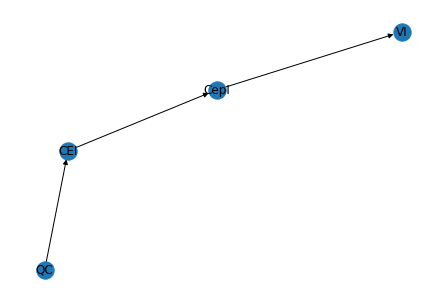

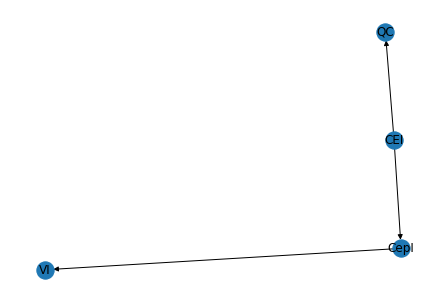

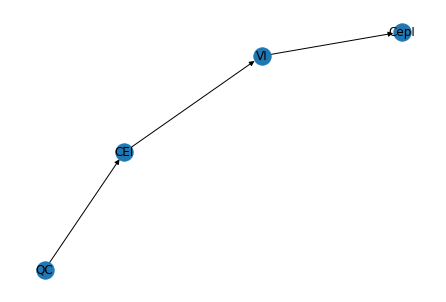

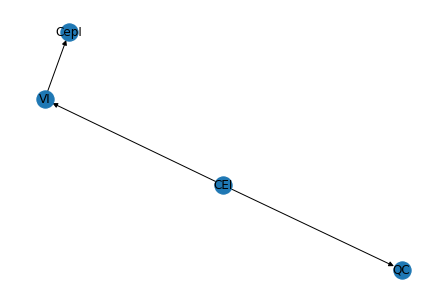

{0: 32, 1: 36, 2: 48, 3: 54}


In [10]:
#------------------------------------------------------------------------------------------------------------------
# Display the unique MSAs for the Root_{sc-NCF}^{*} models and thier frequencies
#------------------------------------------------------------------------------------------------------------------
dpi = 300
mpl.rcParams['figure.dpi']= dpi

graph_list = generate_all_MSTs_with_MFPT (model, constr, BF_type, inedges, BF_lists, noise, plot=False)
graph_distr_freq, graph_distr_lst = get_distribution_graphs (model, constr, BF_type, noise, len(bio_fp))
print (graph_distr_freq)

In [11]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in 
Boolean Gene Regulatory Networks
'''
#------------------------------------------------------------------------------------------------------------------
# Setup for obtaining the correlation heatmaps
#------------------------------------------------------------------------------------------------------------------
model = 'buylla_RSCN_2010A'
constr = 'exact'
BF_type = 'scNCF'
model_name = '$Root_{sc-NCF}^{*}$'

noise = 0.01
pairs = 6 #('3 for zhou and 6 for buylla_RSCN_2010A' Stands for the pairs of attractors to look at)

def bio_fps (path, filename):
    df = pd.read_csv(path + filename, sep = '\t')
    df = df.drop(columns= ['gene'], axis = 1)
    return BN.BitsToIntsFast(np.array(df).T)

bio_fp = bio_fps('../../data/processed_raw/data_for_figs/' + model + '/', 'attractors_' + model + '.tsv')

#order_fp = get_attr_order(path, filename)
order_fp = ['Attractors ' + str(i) + ' & ' + str(j) for i in range(1,len(bio_fp)+1) for j in range(i+1, len(bio_fp)+1)]

def permute_matrix (corr):
    '''
    The correlation matrix is permuted so as to obtain a better color gradient for the corresponding heatmap
    0: BOA
    1: SSP
    2: MFPT
    3: BTR
    4: SIND
    '''
    corr[[1, 3]] = corr[[3, 1]]
    corr[:, 1], corr[:, 3] = corr[:, 3], corr[:, 1].copy()
    
    corr[[2, 4]] = corr[[4, 2]]
    corr[:, 2], corr[:, 4] = corr[:, 4], corr[:, 2].copy()
    return corr


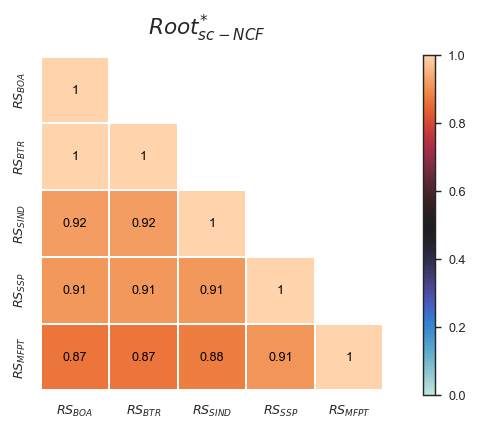

In [12]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in 
Boolean Gene Regulatory Networks
'''
dpi = 130
mpl.rcParams['figure.dpi']= dpi

#------------------------------------------------------------------------------------------------------------------
# Correlation heatmap for cumulative fixed points for different RS measures
#------------------------------------------------------------------------------------------------------------------
def get_heatmap_cumulative (model, constr, BF_type, noise, model_name):
    '''
    model: zhou/buylla_RSCN_2010A (name of the model)
    constr: exact/atleast (fixed point constraint that gives)
    BF_type: scNCF/scEUFs (type of BF used to constrain truth tables)
    noise: noise as a decimal 
    model_name: Root/Panc_{sc-NCF/sc-EUF}^{atleast()/exact(*)} e.g Root_{sc-NCF}^{*}
    '''
    sns.set_style(style='white')
    corr = pd.read_csv ('../../data/processed_raw/data_for_figs/' + model + '/' + constr +  '/' + BF_type + '/correlation/cumulative' +
                   '/CM_' + str(noise) + '.tsv', sep = '\t')
    corr = corr.rename(index={i: corr.columns[i+1] for i in range(5)})
    corr = corr.drop('Unnamed: 0' , axis = 1)
    corr = permute_matrix(np.array(corr))
    matrix = np.triu(corr, k =1)
    x_axis_labels = [r'$\mathit{RS_{BOA}}$',  '$\mathit{RS_{BTR}}$', '$\mathit{RS_{SIND}}$', '$\mathit{RS_{SSP}}$', '$\mathit{RS_{MFPT}}$'] # labels for x-axis
    fig = plt.figure()
    fig.set_size_inches (3.4, 3.4)
#    plt.text (3.2, 0.5, model_name)
    plt.suptitle(model_name)
    sns.heatmap(corr, annot=True, mask=matrix, vmin=0, vmax=1, linewidths= 1, cmap = 'icefire', annot_kws={"fontsize":7, 'color':'black'},
                xticklabels = x_axis_labels, yticklabels= x_axis_labels, cbar = False)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    cb_ax = fig.add_axes([0.99, 0.114, 0.028, 0.77])
    cmap = sns.color_palette("icefire", as_cmap=True)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cb_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=7)
    
### For the sc-NCF cases
##    if constr == 'atleast':    
##        plt.savefig ('../../results/final_figures/new_v1/' + model + '_corr_cum_RSmea.pdf', dpi=600, bbox_inches = 'tight', pad_inches = 0)
##    elif constr == 'exact':
##        plt.savefig ('../../results/final_figures/new_v1/' + model + '_star' +'_corr_cum_RSmea.pdf', dpi=600, bbox_inches = 'tight', pad_inches = 0)

### For the sc-EUF cases
##    if constr == 'atleast':    
##        plt.savefig ('../../results/final_figures/new_v1/' + model + '_' + BF_type +'_corr_cum_RSmea.pdf', dpi=600, bbox_inches = 'tight', pad_inches = 0)
##    elif constr == 'exact':
##        plt.savefig ('../../results/final_figures/new_v1/' + model + '_star_' + BF_type +'_corr_cum_RSmea.pdf', dpi=600, bbox_inches = 'tight', pad_inches = 0)

    plt.show()
    return None

get_heatmap_cumulative (model, constr, BF_type, noise, model_name)

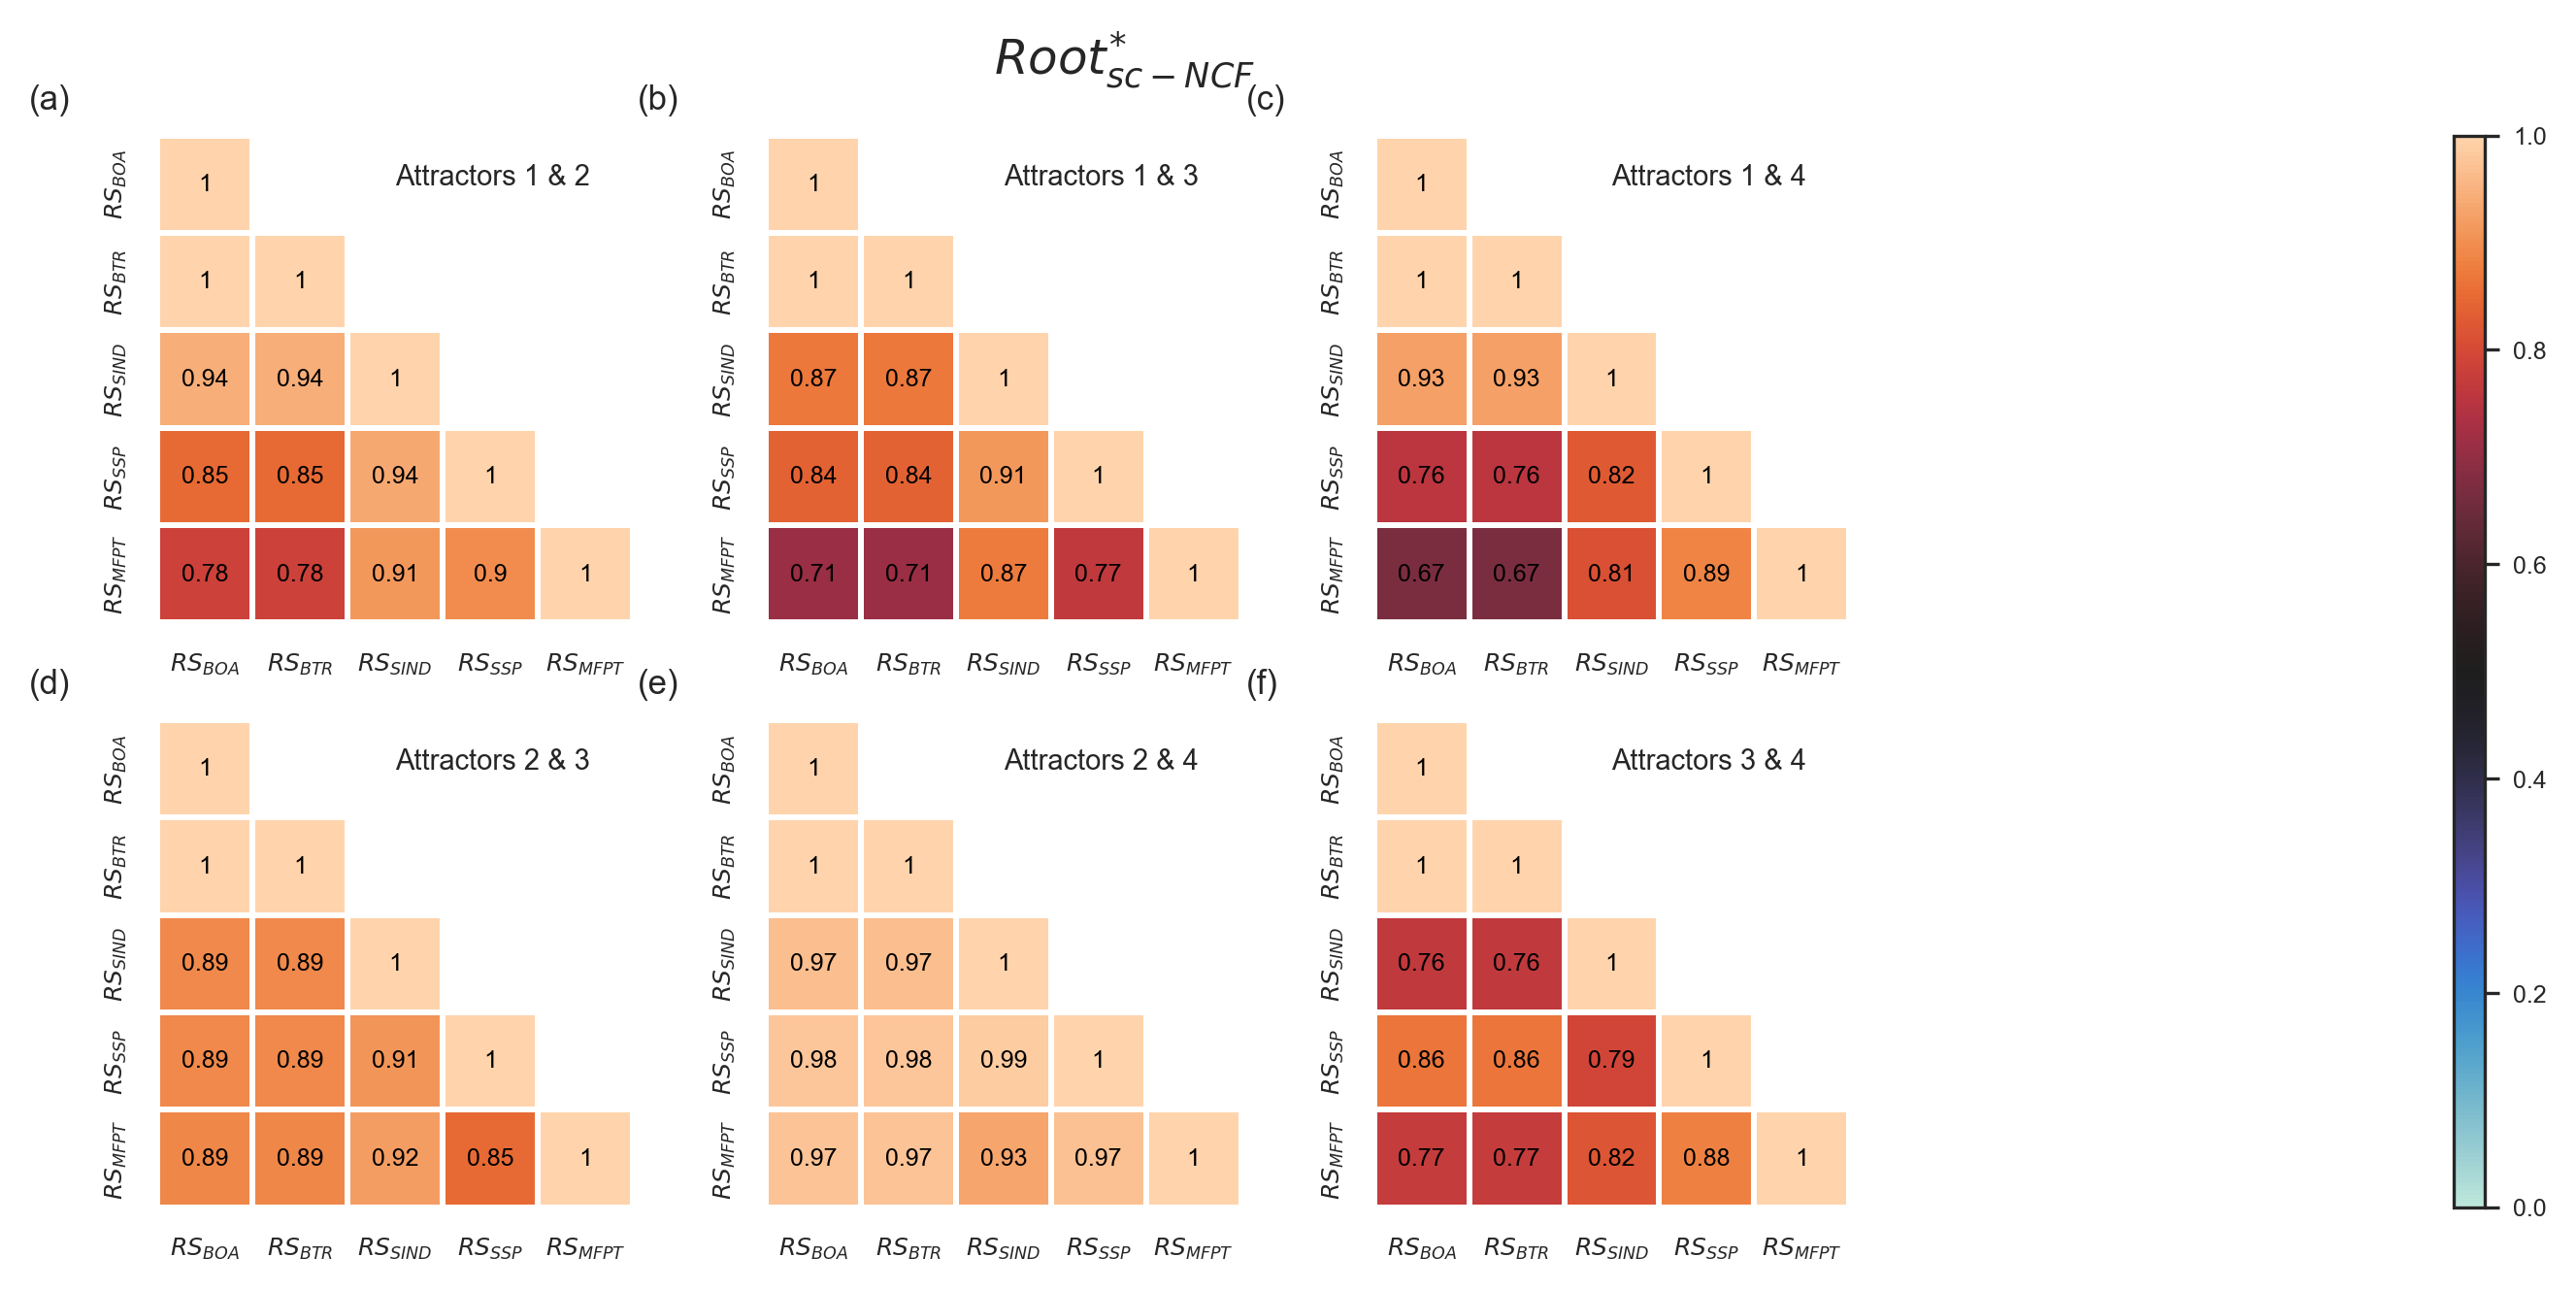

In [13]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in 
Boolean Gene Regulatory Networks
'''
dpi = 300
mpl.rcParams['figure.dpi']= dpi

#------------------------------------------------------------------------------------------------------------------
# Correlation heatmap for pairwise fixed points for different RS measures
#------------------------------------------------------------------------------------------------------------------
def get_heatmap_pairwise (model, pairs, constr, BF_type, order_fp, noise, model_name):
    '''
    model: zhou/buylla_RSCN_2010A (name of the model)
    pairs: Number of unique pairs of biological fixed points for the given model
    constr: exact/atleast (fixed point constraint that gives)
    BF_type: scNCF/scEUFs (type of BF used to constrain truth tables)
    order_fp: List [Attractor i & j] for labelling subplots
    noise: noise as a decimal 
    model_name: Root/Panc_{sc-NCF/sc-EUF}^{atleast()/exact(*)} e.g Root_{sc-NCF}^{*}
    '''

    fig = plt.figure()
    if model == 'buylla_RSCN_2010A':
        fig.set_size_inches (8.3, 4.6)
        fig.suptitle(model_name)
        
    elif model == 'zhou':
        fig.set_size_inches (8.3, 2)
        fig.suptitle(model_name,  y = 1.08)
        
    gs = fig.add_gridspec(int(pairs/3), 3)
    x_axis_labels = [r'$\mathit{RS_{BOA}}$',  '$\mathit{RS_{BTR}}$', '$\mathit{RS_{SIND}}$', '$\mathit{RS_{SSP}}$', '$\mathit{RS_{MFPT}}$'] # labels for x-axis
    y_axis_labels = x_axis_labels
    subfig = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

    for pair in range(pairs):
        corr = pd.read_csv ('../data/' + model + '/' + constr +  '/' + BF_type + '/correlation/pairwise' +
                           '/CM_' +  str(pair) + '_' + str(noise)  + '.tsv', sep = '\t')

        corr = corr.rename(index={i: corr.columns[i+1] for i in range(5)})
        corr = corr.drop('Unnamed: 0' , axis = 1)
        corr = permute_matrix(np.array(corr))
        matrix = np.triu(corr, k =1)
        
        with sns.axes_style("white"):
            ax = fig.add_subplot(gs[pair])
            ax.tick_params(axis='x', rotation=0)
            trans = mtransforms.ScaledTranslation(-20/72, 11/72, fig.dpi_scale_trans)
            ax.text(-0.1, 0.95, subfig[pair], transform=ax.transAxes + trans, fontsize='small', va='bottom', fontfamily='arial') # Buylla

            ax.text (2.5, 0.5, order_fp[pair], fontsize = 7)
            ax.xaxis.set_tick_params(labelsize = 6)
            ax.yaxis.set_tick_params(labelsize = 6)
            plot = sns.heatmap(corr, annot=True, mask=matrix, cmap="icefire", alpha = 1, vmin=0, vmax=1, annot_kws={"fontsize":6, 'color':'black'},   
                            linewidths= 1 ,  xticklabels = x_axis_labels, yticklabels= x_axis_labels, cbar = False)

    cb_ax = fig.add_axes([1.05, 0.1, 0.013, 0.8])
    cmap = sns.color_palette("icefire", as_cmap=True)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cb_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=6)
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.28)

#    if constr == 'atleast':       
#        plt.savefig('../../results/final_figures/new_v1/' + model + '_corr_pair_RSmea.pdf', dpi=600, bbox_inches = 'tight', pad_inches = 0)

#    elif constr == 'exact':
#        plt.savefig('../../results/final_figures/new_v1/' + model + '_star' + '_corr_pair_RSmea.pdf', dpi=600, bbox_inches = 'tight', pad_inches = 0)
        
    plt.show()
    return None

get_heatmap_pairwise (model, pairs, constr, BF_type, order_fp, noise, model_name)


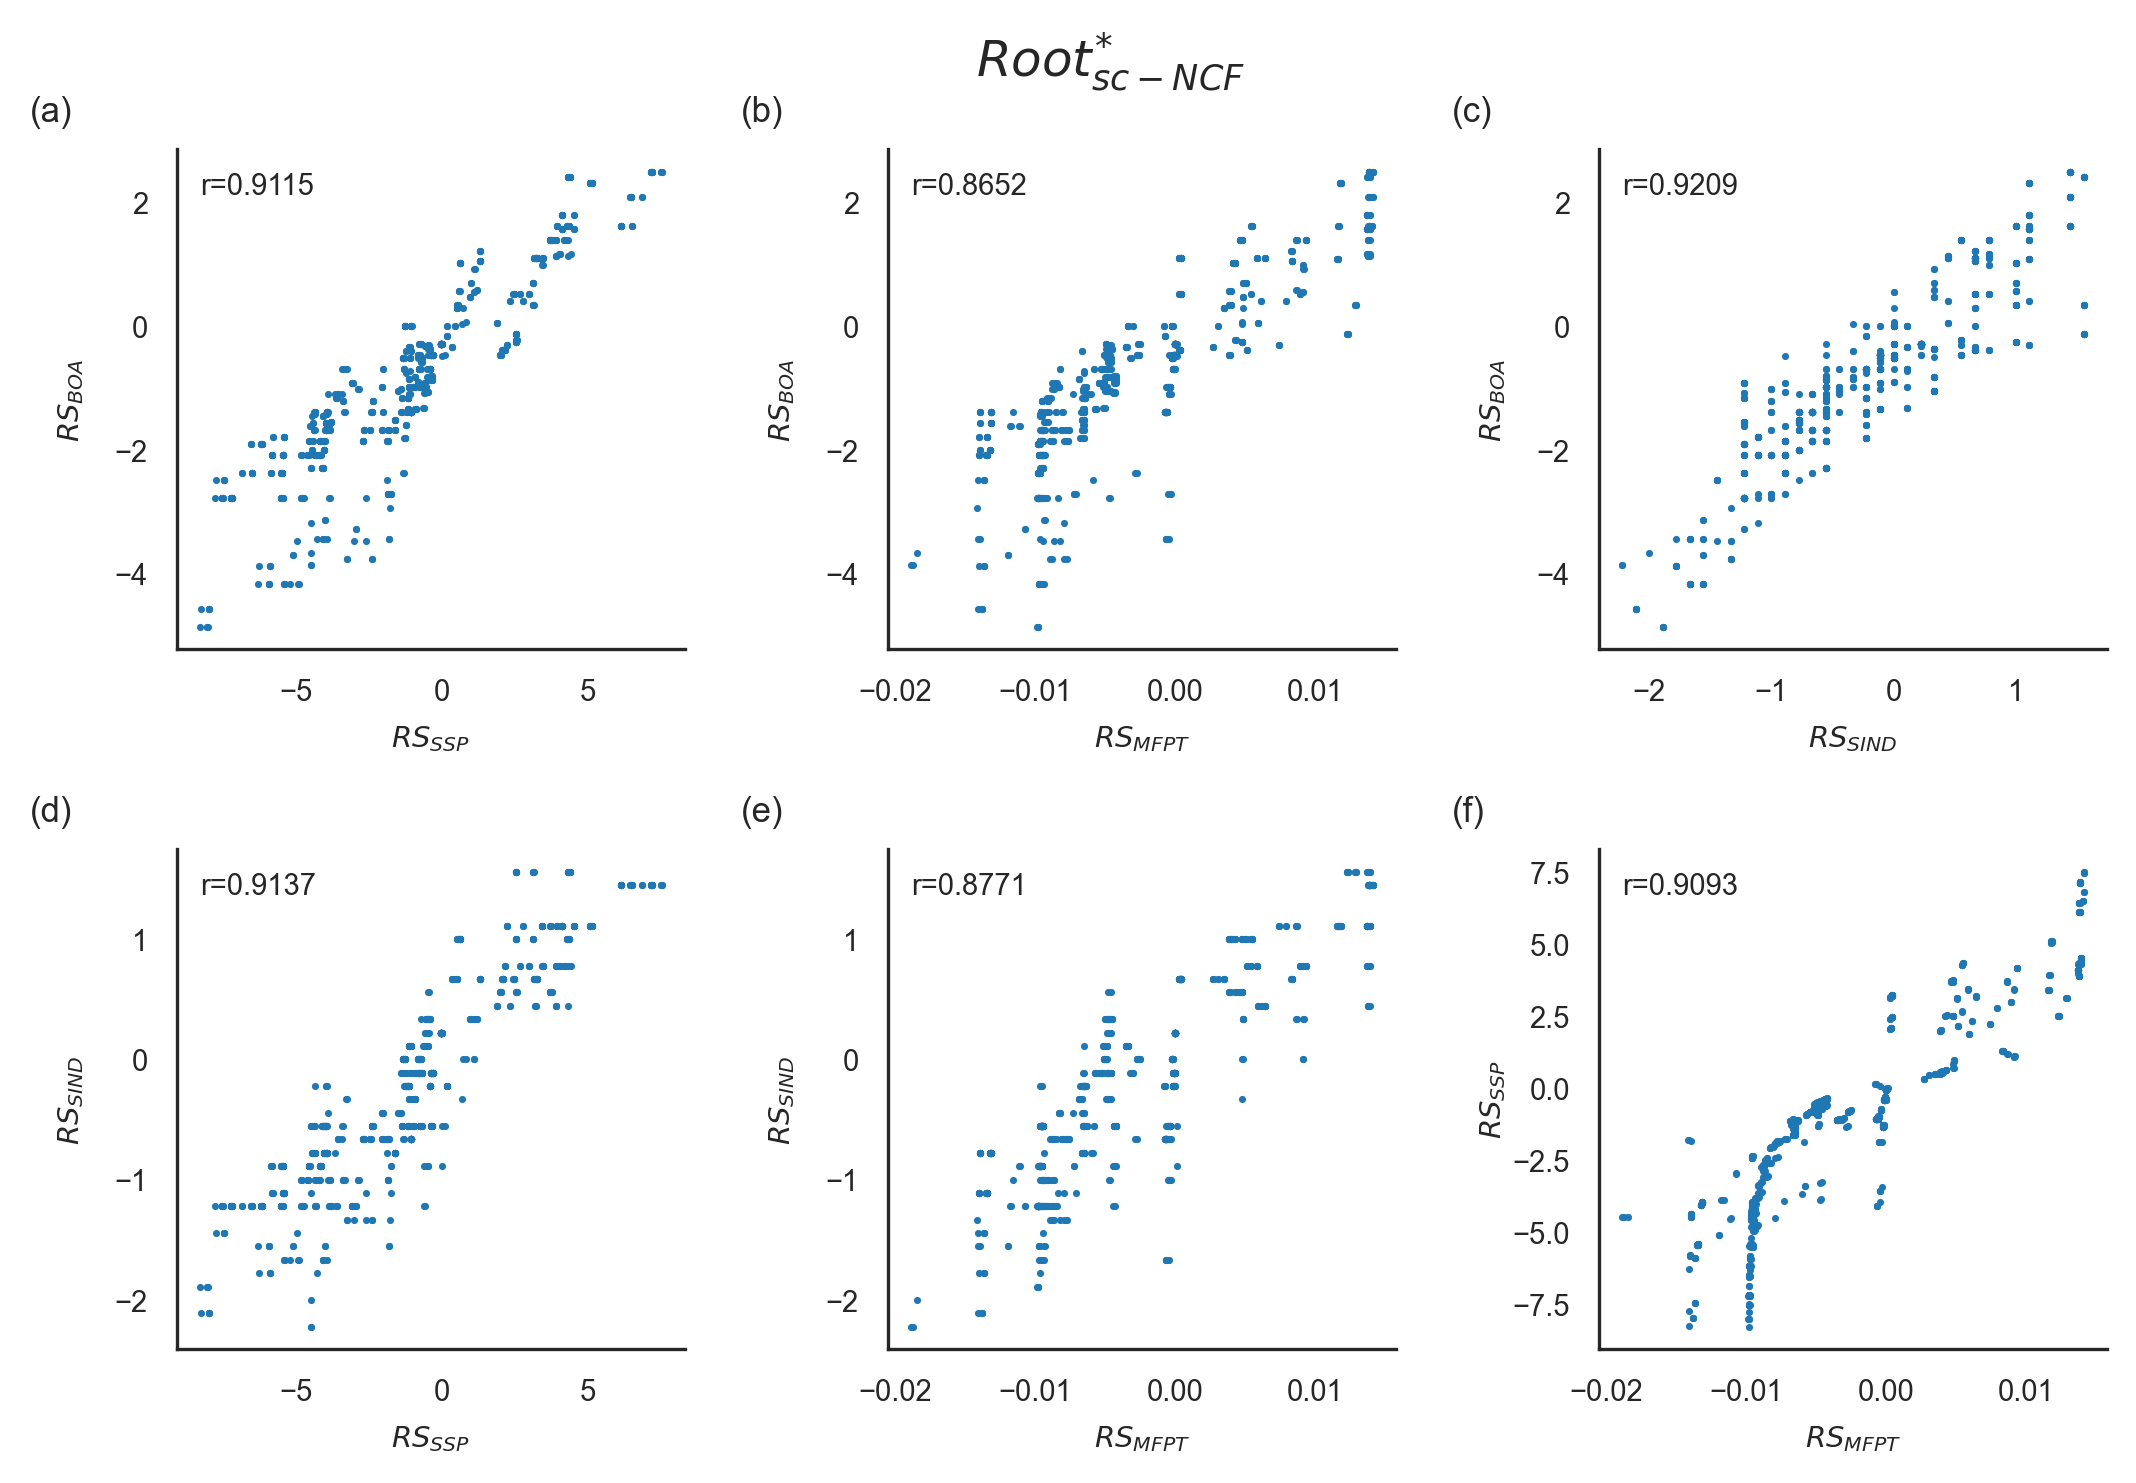

In [14]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in 
Boolean Gene Regulatory Networks
'''
#------------------------------------------------------------------------------------------------------------------
# Scatter plot for pairwise fixed points for different RS measures (done only for cumulative cases for all
# models and RSCN ATLEAST cases for pairwise)
#------------------------------------------------------------------------------------------------------------------
dpi = 300
mpl.rcParams['figure.dpi']= dpi

pair = 2
typ = 'cum' # 'cum' or 'pair'

def get_scatter_plot (model, pair, constr, BF_type, typ ,order_fp, noise, model_name):
    '''
    This code works for both the cumulative case and the pairwise case
    This code need to be implemented only for the RSCN model: ATLEAST case
    model: zhou/buylla_RSCN_2010A (name of the model)
    pair: Particular pair of biological fixed points for which scatter plot is to be made
    constr: exact/atleast (fixed point constraint that gives)
    BF_type: scNCF/scEUFs (type of BF used to constrain truth tables)
    typ: 'cum' (cumulative) or 'pair' (pariwise)
    order_fp: List [Attractor i & j] for labelling subplots (for pairwise case)
    noise: noise as a decimal 
    model_name: Root/Panc_{sc-NCF/sc-EUF}^{atleast()/exact(*)} e.g Root_{sc-NCF}^{*}
    '''
    if typ == 'cum':
        RS_measures = pd.read_csv('../../data/processed_raw/data_for_figs/' + model + '/' + constr +  '/' + BF_type + '/RS_data_' + str(noise) + '.tsv', sep = '\t')

    elif typ ==  'pair':
        RS_measures = pd.read_csv('../../data/processed_raw/data_for_figs/' + model + '/' + constr +  '/' + BF_type + '/RS_data_'+  str(pair) + '_'
                                  + str(noise) + '.tsv', sep = '\t')
        
    D = {0:list(RS_measures['RS_BOA']), 1:list(RS_measures['RS_SSP']), 2:list(RS_measures['RS_MFPT']),
         3:list(RS_measures['RS_BTR']), 4:list(RS_measures['RS_SI'])}
    
    index = {0:'$RS_{BOA}$', 1: '$RS_{SSP}$', 2: '$RS_{MFPT}$', 3: '$RS_{BTR}$', 4: '$RS_{SIND}$'}
    D_ind = {index[ele]:D[ele] for ele in index}

    P = [[i, j] for i in range(0,2) for j in range(0,3)]
    Q = [[1,0], [2,0], [4,0], [1,4], [2,4], [2,1]]

    fig = plt.figure()
    fig.set_size_inches (8.3, 5)
    gs = fig.add_gridspec(2, 3)
    plt.rcParams["figure.autolayout"] = True
    subfig = [['(a)', '(b)', '(c)'], ['(d)', '(e)', '(f)'], ['(g)', '(h)', '(i)']]

    for i in range(len(P)):
        corr_pear = round(np.corrcoef(D[Q[i][0]], D[Q[i][1]])[0,1], 4)
        ax = fig.add_subplot(gs[P[i][0], P[i][1]])
        
        ax.tick_params(axis='x', rotation=0)
        trans = mtransforms.ScaledTranslation(-17/72, 11/72, fig.dpi_scale_trans) 
        ax.text(-0.15, 0.95, subfig[P[i][0]][P[i][1]], transform=ax.transAxes + trans, fontsize='small', va='bottom', fontfamily='arial') # 24:ax.text(-0.18, 0.95, ...) #14:ax.text(-0.15, 0.95, ...) 
        ax.text(min(D[Q[i][0]]), max(D[Q[i][1]]) ,'r={}'.format(corr_pear), fontsize= 7, ha='left', va='top')

        ax.xaxis.set_tick_params(labelsize = 7)
        ax.yaxis.set_tick_params(labelsize = 7)
        ax.scatter(D[Q[i][0]], D[Q[i][1]], s = 0.5)

        ax.yaxis.set_label_coords(-.18, .5) #24:ax.yaxis.set_label_coords(-.23, .5) #14:ax.yaxis.set_label_coords(-.2, .5)

        ax.set_xlabel(index[Q[i][0]], fontsize= 7)
        ax.set_ylabel(index[Q[i][1]], fontsize= 7)

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.4   # the amount of width reserved for blank space between subplots
    hspace = 0.4   # the amount of height reserved for white space between subplots

    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

    if typ == 'cum':
        fig.suptitle(model_name)
#         if  constr == 'atleast': 
#             plt.savefig ('../../results/final_figures/new_v1/' + model + '_scat_' + typ + '_RSmea.pdf', dpi=600, bbox_inches = 'tight', pad_inches = 0)
#         elif constr == 'exact':            
#             plt.savefig ('../../results/final_figures/new_v1/' + model + '_star' + '_scat_' + typ + '_RSmea.pdf', dpi=600, bbox_inches = 'tight', pad_inches = 0)
        
#     elif typ == 'pair':
#         fig.suptitle(model_name + ': '+ order_fp[pair], y = 1)
#         plt.savefig ('../../results/final_figures/new_v1/' + model + '_scat_' + typ + order_fp[pair][-5] + order_fp[pair][-1] +'_RSmea.pdf', dpi=600, bbox_inches = 'tight', pad_inches = 0)        

    plt.show()
    return None

get_scatter_plot (model, pair, constr, BF_type, typ, order_fp, noise, model_name)


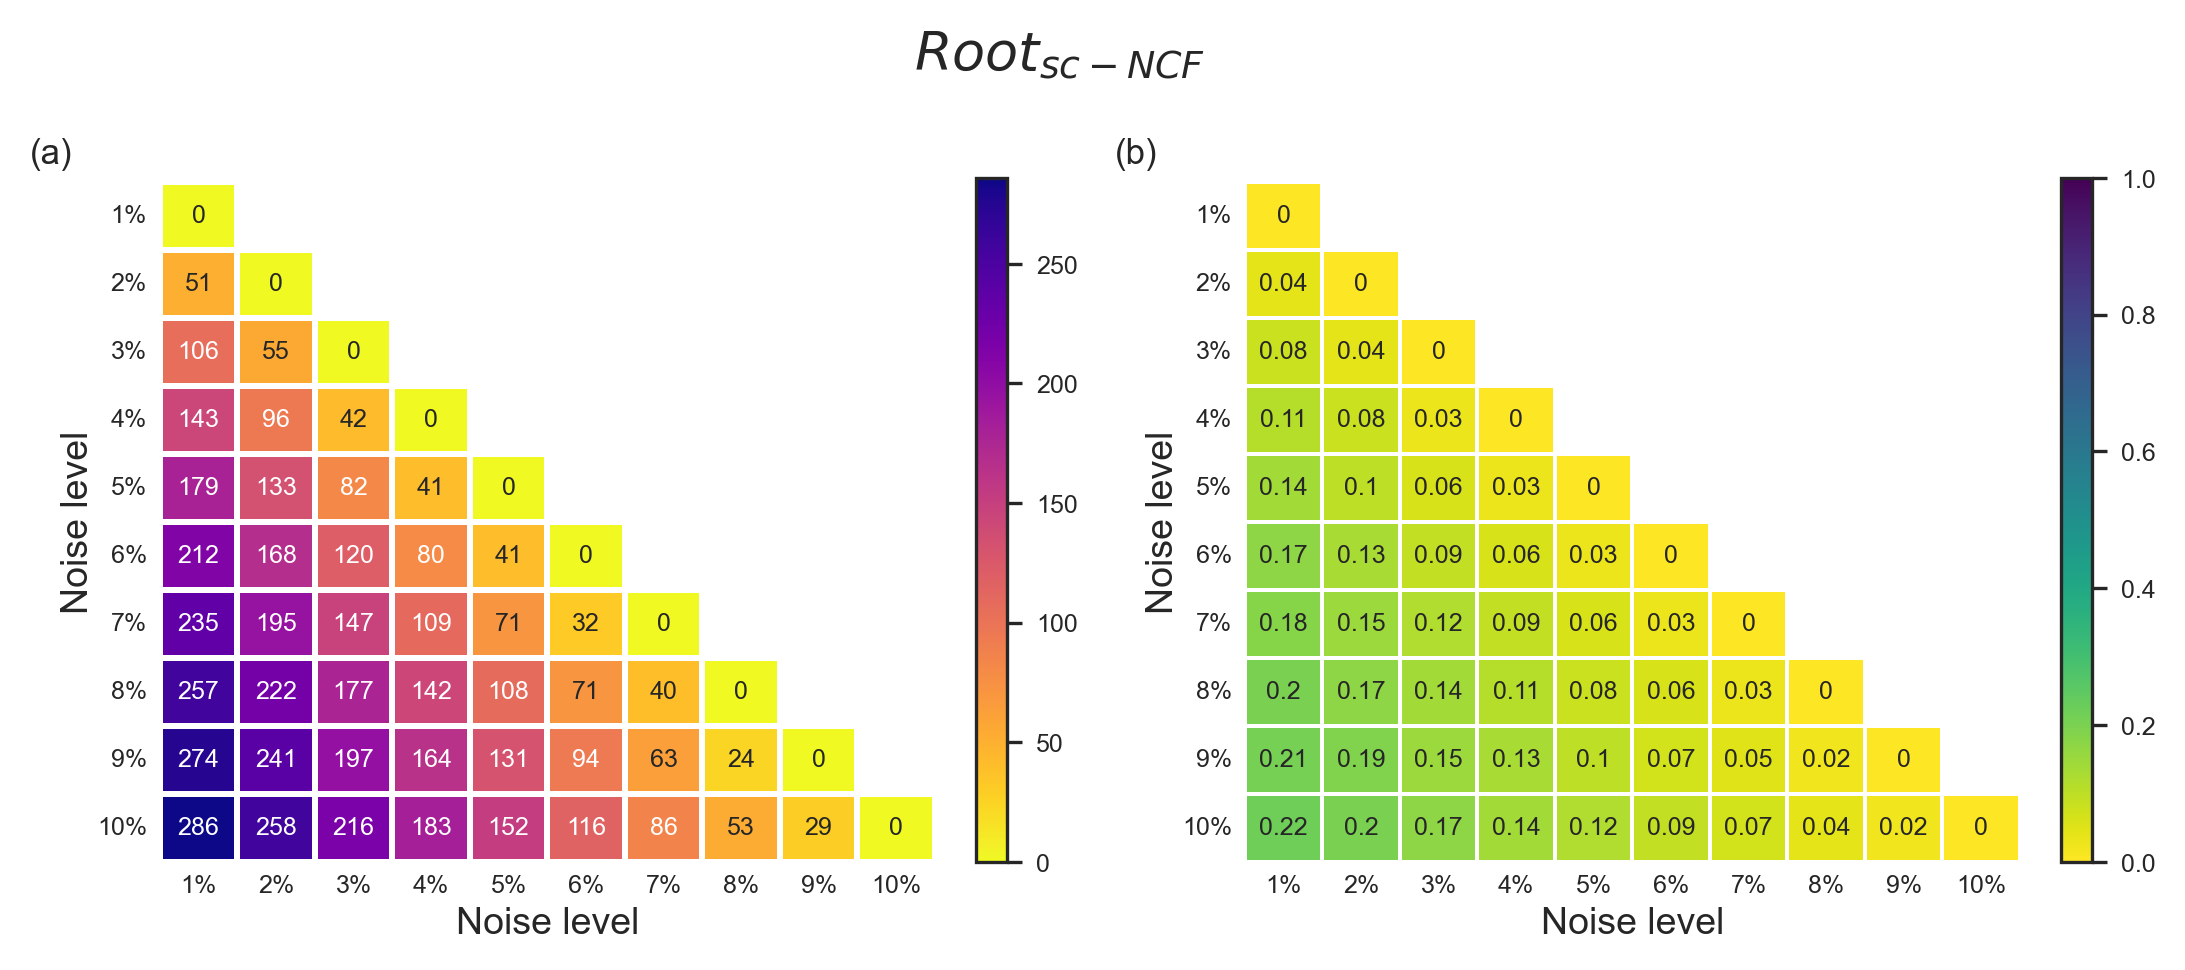

In [27]:
'''
Written by Priyotosh Sil
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in
Boolean Gene Regulatory Networks
'''
#------------------------------------------------------------------------------------------------------------------
# Heatmap for the number and fraction of differences in hierarchies for various pairs of noise values computed
# using the MFPT
#------------------------------------------------------------------------------------------------------------------
dpi = 300
mpl.rcParams['figure.dpi']= dpi

def analytical_MFPT (net_rs, stv, bio_fp, noise):
    T_star = net_rs.T_star(noise, stv)
    ssp = net_rs.SSP(T_star)
    mfpt_ana = net_rs.MFPT_ana(T_star, ssp)
    sub = mfpt_ana[bio_fp][:,bio_fp]
    return sub

def numerical_MFPT (fps, p, trajectories, stv):
    mfpt_mat = RS.MFPT_num (fps, p, trajectories, stv)
    return mfpt_mat[0], mfpt_mat[1]

def get_heatmap_hierarchy (file, BF_lists):
    '''
    Returns two heatmaps. First heatmap gives the actual number of models and the second one provides the 
    fraction of models with respect to all Boolean models.
    file : a tsv file that consists of the number of models for which at least one partial ordering 
          (in terms of MFPT) is different between a pair of noise values.
    BF_lists : list of all sc-NCF Boolean models (each element corresponds to the integer representative
               of a BF at a gene)
                [(11, 1, 2, 2, 1, 1, 1, 2, 1349),
                 (11, 1, 2, 2, 1, 1, 1, 2, 88429909),
                 ,...]
    '''
    df = pd.read_csv(file, sep  ='\t')
    df = df.drop(columns= ['Unnamed: 0'])
    df = df.replace(np.nan, 0)
    x = df.to_numpy()
    d = x + x.T + np.zeros(len(x))
    d1 = d/len(BF_lists)
    d1=d1.round(decimals = 2)
    d = d.astype(int)
    df1 = pd.DataFrame(d)
    df2 = pd.DataFrame(d1)
    df1 = df1.rename(columns = {0:'1%', 1: '2%', 2: '3%', 3: '4%', 4: '5%', 5:'6%', 6:'7%', 7: '8%', 8:'9%', 9:'10%'},
                        index = {0:'1%', 1: '2%', 2: '3%', 3: '4%', 4: '5%', 5:'6%', 6:'7%', 7: '8%', 8:'9%', 9:'10%'},)
    df2 = df2.rename(columns = {0:'1%', 1: '2%', 2: '3%', 3: '4%', 4: '5%', 5:'6%', 6:'7%', 7: '8%', 8:'9%', 9:'10%'},
                        index = {0:'1%', 1: '2%', 2: '3%', 3: '4%', 4: '5%', 5:'6%', 6:'7%', 7: '8%', 8:'9%', 9:'10%'})
    fig = plt.figure()
    gs = fig.add_gridspec(1,2)
    gs.update(wspace=0.4)
    fig.set_size_inches (8, 3)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    trans = mtransforms.ScaledTranslation(-20/72, 11/72, fig.dpi_scale_trans)
    ax1.text(-0.06, 0.95, '(a)', transform=ax1.transAxes + trans,
            fontsize='small', va='bottom', fontfamily='arial')
    ax2.text(-0.06, 0.95, '(b)', transform=ax2.transAxes + trans,
           fontsize='small', va='bottom', fontfamily='arial')
    cb_ax1 = fig.add_axes([0.465, 0.125, 0.013, 0.76])
    cb_ax1.tick_params(labelsize=6)
    cb_ax2 = fig.add_axes([0.917, 0.125, 0.013, 0.76])
    cb_ax2.tick_params(labelsize=6)
    norm1 = mpl.colors.Normalize(vmin=0, vmax=df1.max().max())
    norm2 = mpl.colors.Normalize(vmin=0, vmax=1)
    cmap1 = sns.color_palette("plasma_r", as_cmap=True)
    cmap2 = sns.color_palette("viridis_r", as_cmap=True)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm1, cmap=cmap1), cax=cb_ax1, orientation='vertical')
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=cmap2), cax=cb_ax2, orientation='vertical')
    fig.subplots_adjust(wspace=1)
    mask1 = np.triu(np.ones_like(df1), k =1)
    mask2 = np.triu(np.ones_like(df2), k=1)
    sns.heatmap(df1, vmin = 0.0, vmax = df1.max().max(), cmap="plasma_r", fmt = 'd', annot = True, ax=ax1, mask = mask1, linewidth =1, annot_kws={'size': 6},cbar_kws={'ticks': None}, cbar = False)
    sns.heatmap(df2, vmin = 0.0, vmax = 1, cmap="viridis_r", annot = True, ax=ax2, linewidth =0.5,mask = mask2, annot_kws={'size': 6}, cbar = False)
    ax1.set_xlabel('Noise level', fontname = 'arial', size = 9,labelpad = 2)
    ax1.set_ylabel('Noise level', fontname = 'arial', size = 9,labelpad = 0.5)
    ax2.set_xlabel('Noise level', fontname = 'arial', size = 9,labelpad = 2)
    ax2.set_ylabel('Noise level', fontname = 'arial', size = 9,labelpad = 0.5)
    ax1.tick_params(direction='out', length=2.6, width=0.5,labelsize=6,
               grid_color='r', grid_alpha=0.5, pad = 0.5, rotation = 0)
    ax2.tick_params(direction='out', length=2.6, width=0.5,labelsize=6,
               grid_color='r', grid_alpha=0.5, pad = 0.5, rotation = 0)
    fig.suptitle("$Root_{sc - NCF}$", fontsize=13, y= 1.05)
#    fig.set_tight_layout(False) # Added for proper display; remove while saving figure
    plt.show()
#    plt.close()
#    fig.savefig('../plots/Root_mismatch_hier.pdf', dpi = 600, bbox_inches= 'tight', pad_inches = 0)
    return None


with open ("../data/buylla_RSCN_2010A/atleast/scNCF/atleast_scNCF.pkl", 'rb') as file:
     BF_lists = pkl.load(file)

file = '../data/buylla_RSCN_2010A/atleast/scNCF/hierarchy_change_with_noise.tsv'
get_heatmap_hierarchy(file, BF_lists)

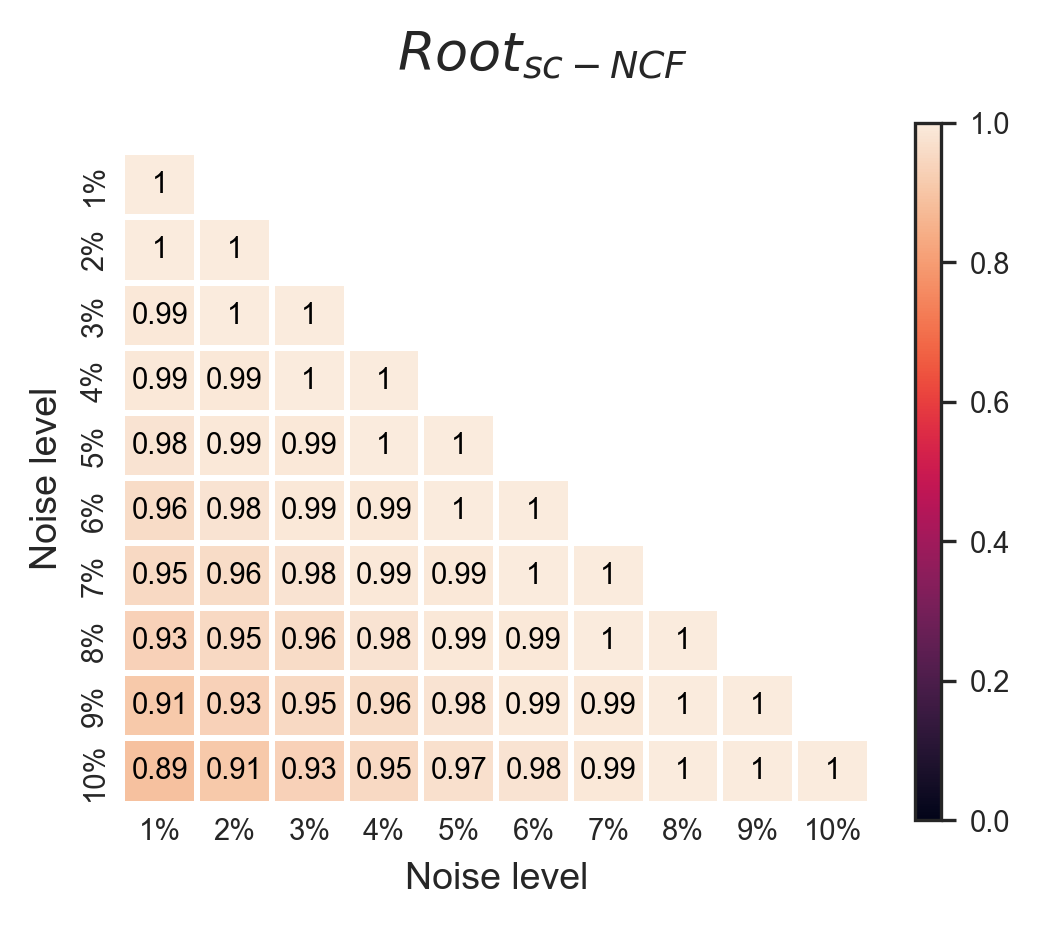

In [16]:
'''
Written by Priyotosh Sil
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in 
Boolean Gene Regulatory Networks
'''
dpi = 300
mpl.rcParams['figure.dpi']= dpi

#------------------------------------------------------------------------------------------------------------------
# Heatmap for the correlation between RS_MFPT for different pairs of noise intensities
#------------------------------------------------------------------------------------------------------------------
def get_heatmap_corr_rsmfpt (file):
    '''
    returns a heatmap consists of the input values.
    file: a tsv file that consists of the Pearson correlation coefficients of RS_MFPT values for a pair of noise levels. 
    '''
    
    df = pd.read_csv( file ,sep  ='\t')
    df = df.drop(columns= ['Unnamed: 0'])
    df = df.replace(np.nan, 0)
    x = df.to_numpy()
    d = x + x.T+ np.identity(len(x))
    d=d.round(decimals = 2)
    df = pd.DataFrame(d)
    corr_df = df.rename(columns = {0:'1%', 1: '2%', 2: '3%', 3: '4%', 4: '5%', 5:'6%', 6:'7%', 7: '8%', 8:'9%', 9:'10%'},
                        index = {0:'1%', 1: '2%', 2: '3%', 3: '4%', 4: '5%', 5:'6%', 6:'7%', 7: '8%', 8:'9%', 9:'10%'})
    mask = np.triu(np.ones_like(corr_df),k=1)
    fig,ax1 = plt.subplots()
    plt.suptitle("$Root_{sc - NCF}$",x=0.6, fontsize=13)
    ax1.tick_params(direction='out', length=2.6, width=0.5,labelsize=6,
               grid_color='r', grid_alpha=0.5, pad = 0.7)
    fig.set_size_inches (3.1, 3.1)
    sns.heatmap(corr_df, annot=True, mask=mask, vmin=0, vmax=1, linewidths= 1, cmap = 'rocket', annot_kws={"fontsize":7, 'color':'black'},cbar = False)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    ax1.set_xlabel('Noise level', fontname = 'arial', size = 9)
    ax1.set_ylabel('Noise level', fontname = 'arial', size = 9)
    cb_ax = fig.add_axes([1, 0.13, 0.028, 0.75])
    cmap = sns.color_palette("rocket", as_cmap=True)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cb_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=7)
#    plt.savefig('../plots/Root_corr_diff_noise.pdf', dpi = 600, bbox_inches= 'tight', pad_inches = 0)
    plt.show()
    plt.close()
    return None

file3 = '../data/buylla_RSCN_2010A/atleast/scNCF/ana_rsmfpt_noise_corr_cum.tsv'
get_heatmap_corr_rsmfpt (file3)

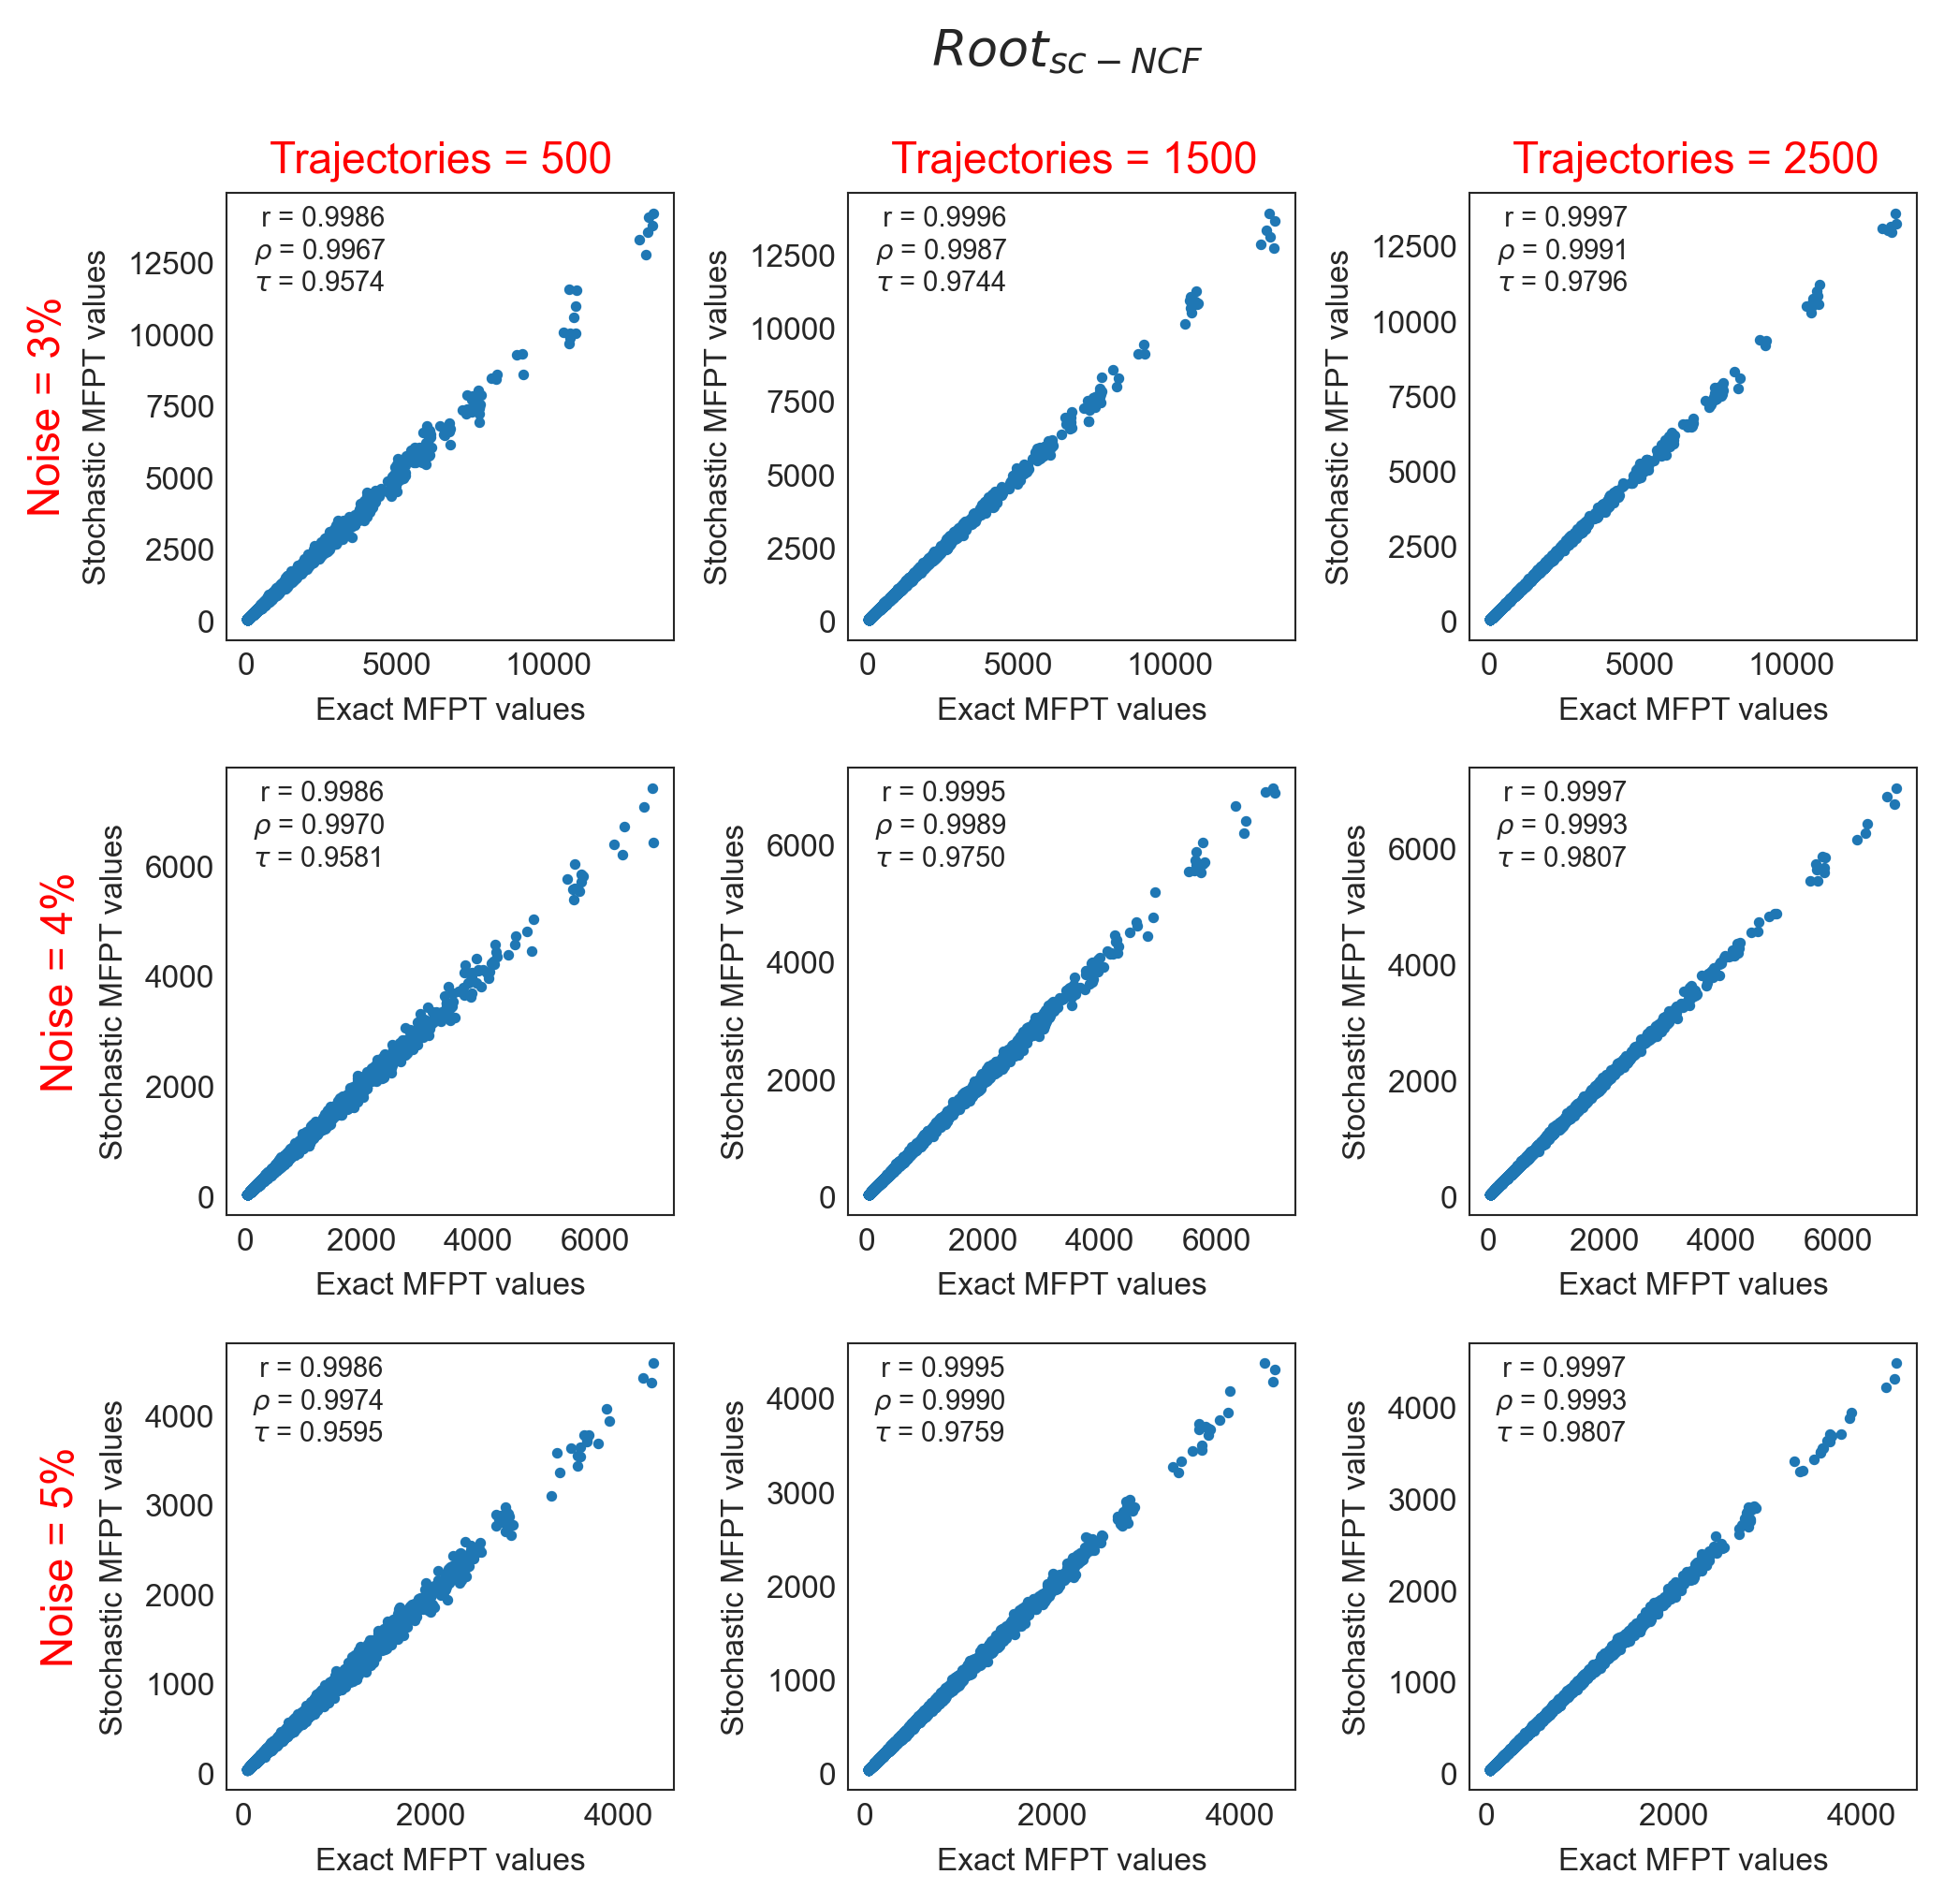

In [17]:
'''
Written by Priyotosh Sil
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in Boolean Gene Regulatory Networks
'''
#------------------------------------------------------------------------------------------------------------------
# Scatter plot for the correlation between exact and stochastic methods to compute MFPT for different pairs of 
# noise intensities
#------------------------------------------------------------------------------------------------------------------
dpi = 300
mpl.rcParams['figure.dpi']= dpi

def scatsubplot_ana_vs_num_mfpt(file):
    '''
    returns scatter plots of analytical and numerical MFPT values for different combination of number of trajectories
    and noise levels.
    file: Contains the analytical and numerical MFPT values for different noise levels (3%,4% and 5%)
    and different number of trajectories (500,1500,2500).
    '''
    iteration = [500, 1500, 2500]
    noi_val = [3, 4, 5]
    df1 = pd.read_csv(file, sep = '\t')
    fig, axs = plt.subplots(3,3,facecolor='w', edgecolor='k', figsize=(8,8))
    plt.suptitle("$Root_{sc - NCF}$",x=0.54, y= 0.99, fontsize=13)
    fig.subplots_adjust(hspace = .1, wspace=.005)
    trans = mtransforms.ScaledTranslation(-20/72, 11/72, fig.dpi_scale_trans)
    axs = axs.ravel()
    fig.set_size_inches(7.1, 6.8)
    fig.set_tight_layout(True)
    plt.rcParams["figure.autolayout"] = True
    for i in range(len(df1['Iterations'])):
        analist = eval(df1['analytic_values'].values[i])
        numlist = eval(df1['numer_values'].values[i])
        pearcoeff = '%.4f'%(pearsonr(analist, numlist)[0])
        spearman = '%.4f'%(spearmanr(analist,numlist)[0])
        kenda = '%.4f'%(stats.kendalltau(analist,numlist)[0])
        axs[i].set_box_aspect(1)
        axs[i].scatter(analist,numlist,s =3)
        axs[i].set_xlabel('Exact MFPT values',fontname = 'arial', size = 8, fontweight = 'regular')
        axs[i].set_ylabel('Stochastic MFPT values',fontname = 'arial', size = 8, fontweight = 'regular')
        axs[i].text(5, 0.81*max(numlist),'  r = {corr_pear} \n $\\rho$ = {corr_sp} \n $\\tau$ = {corr_ken}'
                .format(corr_pear =pearcoeff, corr_sp = spearman, corr_ken = kenda), fontsize = 7)
        for axis in ['top','bottom','left','right']:
              axs[i].spines[axis].set_linewidth(0.5)
        axs[i].tick_params(direction='out', length=2.6, width=0.5,labelsize=8,
                   grid_color='r', grid_alpha=0.5, pad = 0.5)
        if i<3:
            axs[i].text(0.27, 0.93, 'Trajectories = {}'.format(iteration[i]), transform=axs[i].transAxes + trans,
                    fontsize= 11, va='bottom', fontfamily='arial', color = 'red')
        if i == 0:
            axs[i].text(-0.27, 0.18, 'Noise = {}%'.format(noi_val[int(i/3)]), transform=axs[i].transAxes + trans,
                    fontsize= 11, va='bottom', fontfamily='arial', color = 'red', rotation = 90)     
        if i in [3,6]:
            axs[i].text(-0.24, 0.18, 'Noise = {}%'.format(noi_val[int(i/3)]), transform=axs[i].transAxes + trans,
                    fontsize= 11, va='bottom', fontfamily='arial', color = 'red', rotation = 90)
#        fig.savefig('../plots/Root_ana_num_scatter.pdf', dpi = 600, bbox_inches= 'tight', pad_inches = 0)
        #print(noise,ite)
    plt.show() ## Due to default Jupyter noteook environment all subplots are not coming properly here. But the 
                   ## saved figures can be seen properly.
    plt.close()
            
file = '../data/buylla_RSCN_2010A/atleast/scNCF/analist_and_numlist_data.tsv'
scatsubplot_ana_vs_num_mfpt(file)

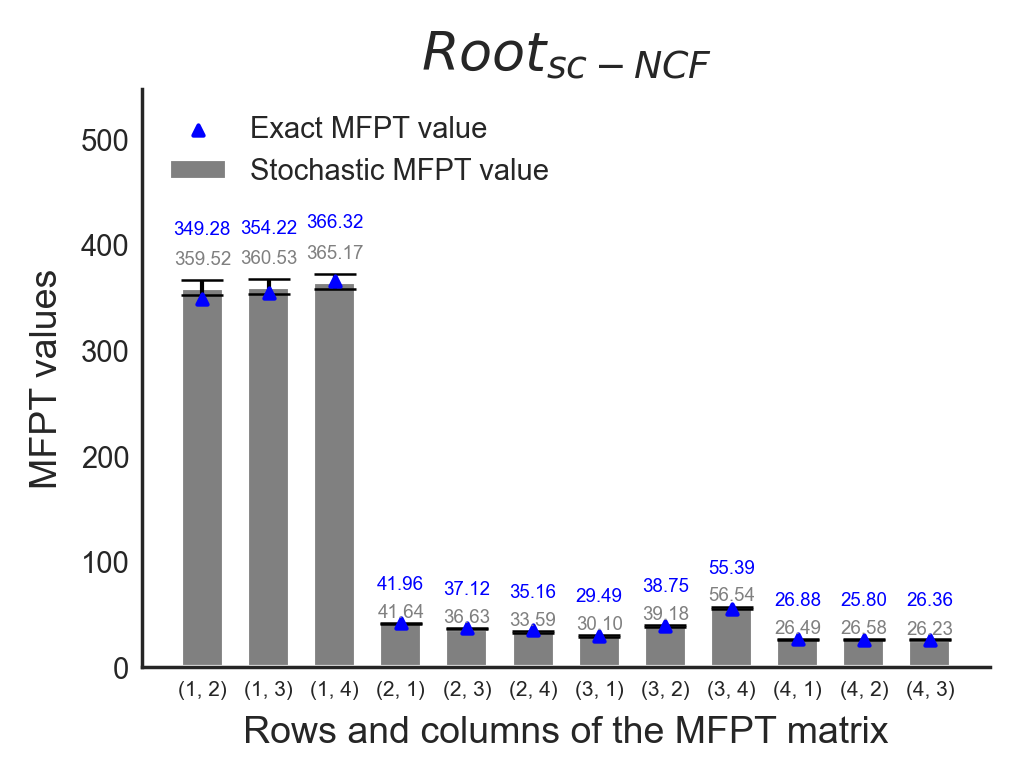

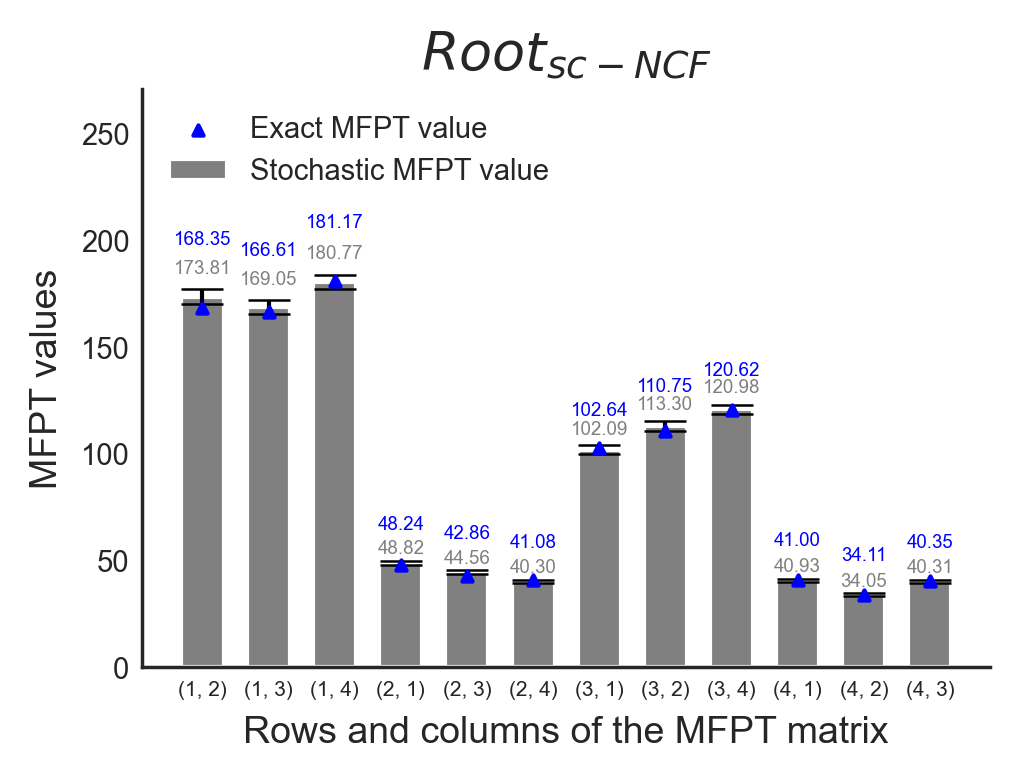

In [28]:
'''
Written by Priyotosh Sil
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in Boolean Gene Regulatory Networks
'''

#------------------------------------------------------------------------------------------------------------------
# Bar plot of the MFPT from one biological attractor to another (both stochastic and exact computations)
#------------------------------------------------------------------------------------------------------------------
dpi = 300
mpl.rcParams['figure.dpi']= dpi

model = 'buylla_RSCN_2010A'
constr = 'atleast'
BF_type = 'scNCF'
noise = 0.01

with open ('../data/'+ model + '/node_num.pkl', 'rb') as file:
    node_num = pkl.load(file)

with open ('../data/'+ model + '/inedges.pkl', 'rb') as file:
    inedges = pkl.load(file)

with open ('../data/' + model + '/' + constr +  '/' + BF_type + '/' + constr + '_' + BF_type + '.pkl', 'rb') as file:
    BF_lists = pkl.load(file)

attrs = pd.read_csv('../data/' + model + '/attractors_' + model + '.tsv', sep = '\t')
attrs_new = attrs.drop(columns= ['gene'], axis = 1)
bio_fp = BN.BitsToIntsFast(np.array(attrs_new).T)
attr_num = {attrs_new.columns[i]:bio_fp[i] for i in range(len(bio_fp))}
modlist = [45, 90]

def bio_fps ():
    df1 = pd.read_csv('../data/.tsv', sep = '\t')
    attrlist = list(df1)[1:]
    df1 = df1.drop(columns= ['gene'], axis = 1)
    return BN.BitsToIntsFast(np.array(df1).T), attrlist

######################################################################################################
######################################################################################################

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
       height = rect.get_height()
       ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' %(height),
       color = 'grey', ha='center', va='bottom', size = 4.5)   
    return None
   
def barplot_ana_num(BF_lists, inedges, fps, mod_list):
    '''
    returns barplots. Here the height of the barplots is the numerical MFPT values and the ordinate 
    of the blue scatter points are the corresponding analytical MFPT values. 
    BF_lists : list of all sc-NCF Boolean models (Integer representative of Boolean functions)
                [[11, 1, 2, 2, 1, 1, 1, 2, 1349],
                 [11, 1, 2, 2, 1, 1, 1, 2, 88429909],
                 ,...]
    inedges : inedge dictionary {0: [5, 0, 6, 7], 1: [2], 2: [3], 3: [4], 4: [4], 5: [5], 6: [5, 0], 7: [5, 0, 8],
                                 8: [2, 5, 0, 7, 8]} This gives the inputs to all nodes in the network.
    fps: Fixed points for the model
         array([477, 216, 478, 208]). Array of integer representative of fixed points.
    mod_list: The list of models for those we want to get the barplots.
    '''
    entry = []
    allatt1 = list(np.arange(1,len(fps)+1))
    listcomb = []
    for l in allatt1:
        for m in allatt1:
            if l != m:
                listcomb.append(str(l)+str(m))
    for n in range(len(listcomb)):
        listcomb[n] = {int(listcomb[n])}
    for item in listcomb:
        entry.append(str(((int(str(item)[1])), int(str(item)[2]))))
    
    for item in mod_list:
        analist,numlist,errolist = [],[],[]
        BF_list = BF_lists[item] # By changing the BF_list you can change the model

        net_rs = RS(inedges, BF_list, fps)
        stv = net_rs.STV()
        ana = analytical_MFPT (net_rs, stv, fps, 0.05)
        numer = numerical_MFPT (fps, 0.05, 2500, stv)

        for j in range(len(fps)):
            for k in range(len(fps)):
                if j != k:
                    analist.append(ana[j][k])
                    numlist.append(numer[0][j][k])
                    errolist.append(numer[1][j][k])
        means = numlist
        anameans = analist
        std= errolist
        width = 0.65
        fig, ax = plt.subplots()
        plt.title("$Root_{sc - NCF}$",x=0.5, y= 0.99, fontsize=13)
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        for axis in ['left', 'bottom']:
           ax.spines[axis].set_linewidth(0.83)
        plt.rcParams["figure.figsize"] = [3.5, 2.7]
        barfig = ax.bar(entry, means, width, color= 'grey', yerr=std, align = 'center', error_kw = dict(lw=1, capsize=5, capthick=0.6))
        cross = ax.scatter(entry,anameans, marker = '^', zorder = 2, color = 'blue', s=6)
        plt.legend(['Exact MFPT value', 'Stochastic MFPT value'], loc = 'upper left', frameon=False, fontsize= 7)
        uplim = 1.3*np.max(numlist)
        ax.set_ylim(0 , 1.5*np.max(numlist))
        for i, txt in enumerate(analist):
            if numlist[i] < 0.53*uplim:
               ax.annotate('%.2f' %(txt), (entry[i], analist[i]), color = 'blue', xytext=(entry[i], numlist[i]+0.06*uplim), ha='center', va='bottom',size = 4.5)
            else:
              ax.annotate('%.2f' %(txt), (entry[i], analist[i]), color = 'blue', xytext=(entry[i],1.13*numlist[i]), ha='center', va='bottom', size = 4.5)
        autolabel(barfig,ax)
        ax.set_ylabel('MFPT values',fontname = 'arial', size = 9)
        ax.set_xlabel('Rows and columns of the MFPT matrix',fontname = 'arial', size = 9)
        ax.tick_params(axis = 'x', direction='out', length=2.6, width=0.5,labelsize=5,
                   grid_color='r', grid_alpha=0.5, pad = 0.5)
        ax.tick_params(axis = 'y', direction='out', length=2.6, width=0.5,labelsize=7,
                   grid_color='r', grid_alpha=0.5, pad = 0.5)
        #plt.savefig('../plots/Root_ana_num_barplot.pdf', dpi = 600, bbox_inches= 'tight', pad_inches = 0)
        plt.show()
    return None #means,anameans,std
barplot_ana_num(BF_lists, inedges, bio_fp, modlist)

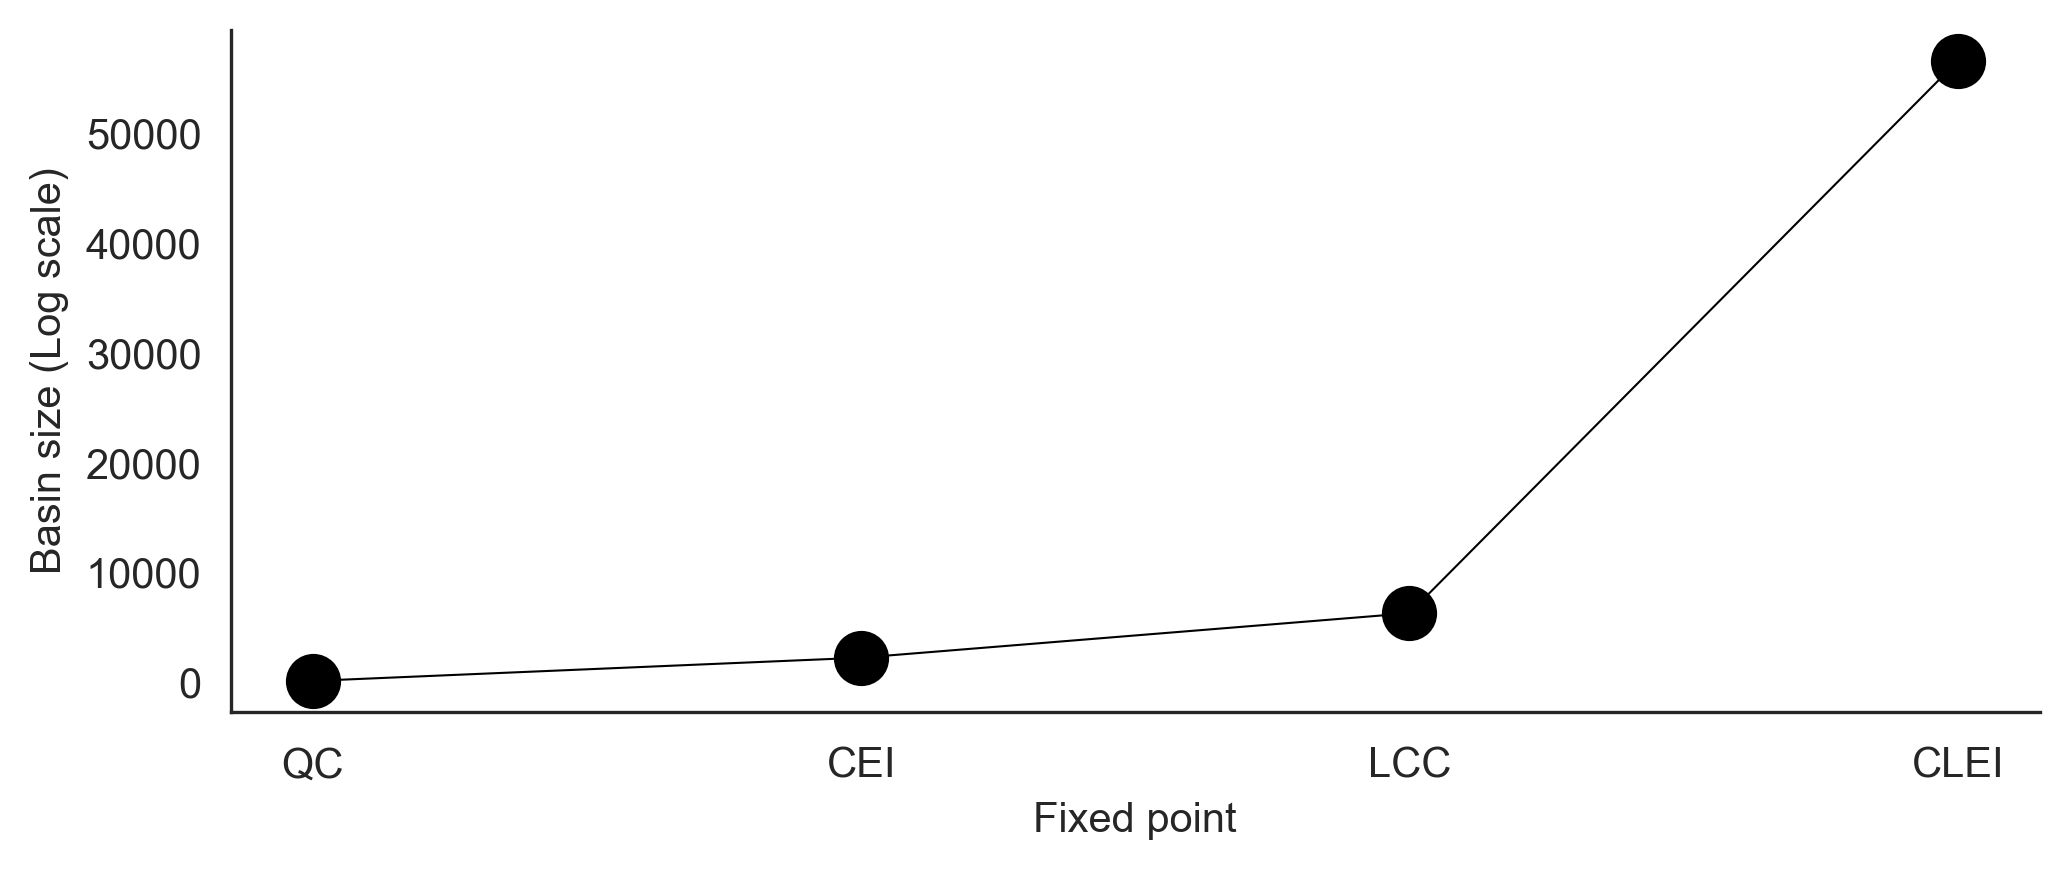

{'QC': 170, 'CEI': 2286, 'LCC': 6336, 'CLEI': 56624}

In [29]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in 
Boolean Gene Regulatory Networks
'''
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate figures for the basin of attraction and the minimum spanning tree for the RSCN models
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
dpi = 300
mpl.rcParams['figure.dpi']= dpi

model = 'buylla_RSCN_2013'

with open ('../../data/processed_raw/data_for_figs/'+ model + '/node_num.pkl', 'rb') as file:
    node_num = pkl.load(file)

with open ('../../data/processed_raw/data_for_figs/'+ model + '/inedges.pkl', 'rb') as file:
    inedges = pkl.load(file)

with open ('../../data/processed_raw/data_for_figs/'+ model + '/BF_list.pkl', 'rb') as file:
    BF_list = pkl.load(file)

def get_pairwise_BOA_hierarchy(model, inedges, BF_list):
    '''
    '''
    atrs = pd.read_csv('../../data/processed_raw/data_for_figs/' + model + '/' + 'attractors_' + model + '.tsv', sep = '\t')
    atrs = atrs.drop(['gene'], axis = 1)
    biofp = BN.BitsToIntsFast(np.array(atrs).T)
    atr_name = {biofp[i]: atrs.columns[i] for i in range(len(biofp))}
    net_rs = RS(inedges, BF_list, biofp)
    stv = net_rs.STV()
    boa = net_rs.basin_sizes_fps (stv)
    d = {atr_name[fp]:boa[fp] for fp in boa}
    fig, ax = plt.subplots(figsize = (7, 3))
    ax.scatter(d.keys(), d.values(), color= 'black', s=150)
    ax.plot(d.keys(), d.values(), color= 'black', linewidth= '0.5')
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
##    ax.set_xtick_labels (fontsize = 10)
##    ax.set_ytick_labels (fontsize = 10)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xlabel('Fixed point')
    ax.set_ylabel('Basin size (Log scale)')
    ax.tick_params(axis='x', which='major', pad=5)
#    plt.savefig('../../data/processed_raw/data_for_figs/buylla_RSCN_2020/BOA_hier' + model + '_v3.pdf')
#    plt.tight_layout()
    plt.show()
    plt.close()
    return d

get_pairwise_BOA_hierarchy(model, inedges, BF_list)



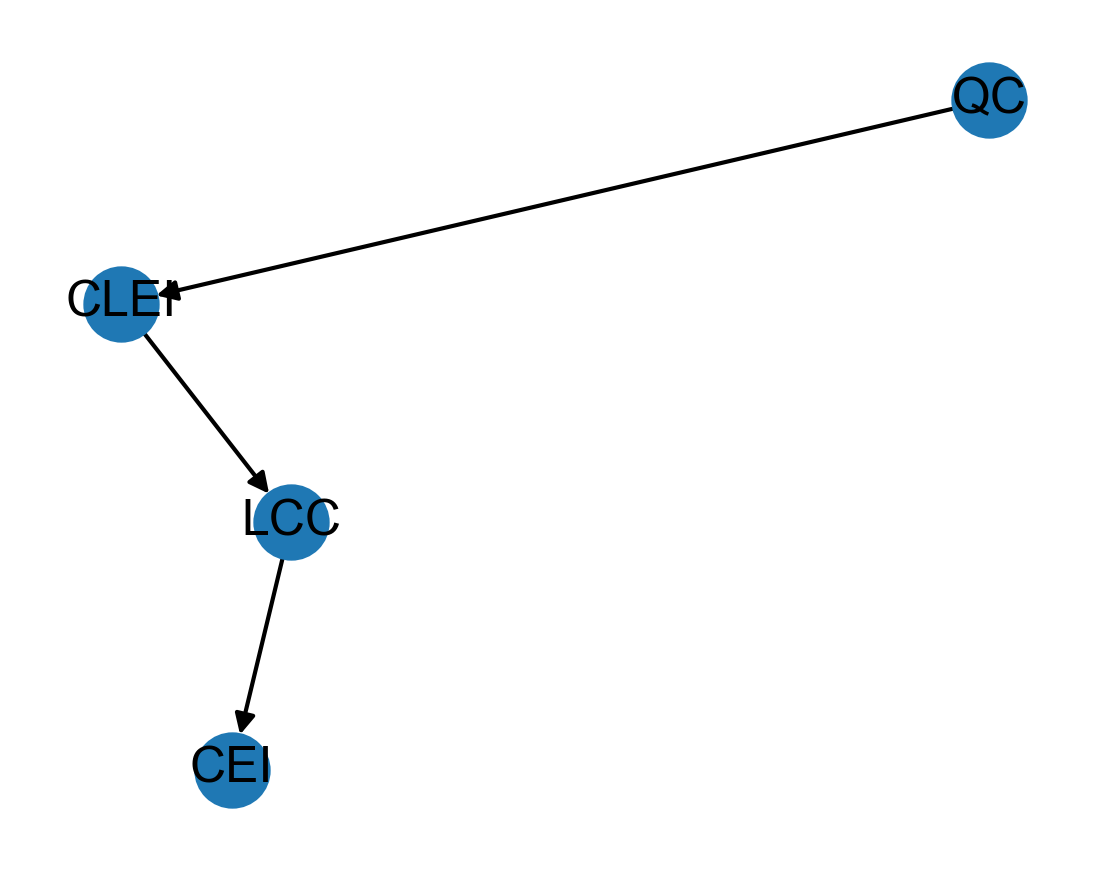

In [31]:
noise = 0.05
trajectories = 1000 #To be made 10000
dpi = 300
mpl.rcParams['figure.dpi']= dpi

def MFPT_MST_hiers (model, inedges, BF_list, noise, trajectories, plot=False):
    '''
    '''
    atrs = pd.read_csv('../../data/processed_raw/data_for_figs/' + model + '/' + 'attractors_' + model + '.tsv', sep = '\t')
    atrs = atrs.drop(['gene'], axis = 1)
    biofp = BN.BitsToIntsFast(np.array(atrs).T)
    atr_name = {biofp[i]: atrs.columns[i] for i in range(len(biofp))}

    net_rs = RS(inedges, BF_list, biofp)
    stv = net_rs.STV()
    E_mfpt = []
    MFPT_hier = []
    M = np.zeros([len(biofp), len(biofp)])
    E = np.zeros([len(biofp), len(biofp)])
    for i in range(len(biofp)):
        u = biofp[i]
        for j in range(i+1, len(biofp)):
            v = biofp[j]
            M_uv = RS.MFPT_num_2_states (u, v, noise, trajectories, stv)
            M_vu = RS.MFPT_num_2_states (v, u, noise, trajectories, stv)
            m_uv, er_uv = M_uv['mfpt'], M_uv['sterr']
            m_vu, er_vu = M_vu['mfpt'], M_vu['sterr']
            M[i, j], E[i, j] = m_uv, er_uv
            M[j, i], E[j, i] = m_vu, er_vu
            E_mfpt += [(atr_name[v], atr_name[u], m_uv), (atr_name[u], atr_name[v], m_vu)] # add_weighted edges function take 'from' to 'to' edge
            
            if (m_uv + er_uv > m_vu - er_vu) and (m_uv + er_uv < m_vu + er_vu):
                MFPT_hier += [atr_name[u] + ' X ' + atr_name[v]]
                
            elif (m_uv - er_uv > m_vu - er_vu) and (m_uv + er_uv < m_vu + er_vu):
                MFPT_hier += [atr_name[u] + ' X ' + atr_name[v]]
                
            elif (m_vu + er_vu > m_uv - er_uv) and (m_vu + er_vu < m_uv + er_uv):
                MFPT_hier += [atr_name[u] + ' X ' + atr_name[v]]

            elif (m_vu - er_vu > m_uv - er_uv) and (m_vu + er_vu < m_uv + er_uv):
                MFPT_hier += [atr_name[u] + ' X ' + atr_name[v]]

            else:
                if m_uv > m_vu:
                    MFPT_hier += [atr_name[u] + ' < ' + atr_name[v]]
                                 
                elif m_uv < m_vu:
                    MFPT_hier += [atr_name[u] + ' > ' + atr_name[v]]
                
    mfpt_graph = nx.DiGraph()
    mfpt_graph.add_weighted_edges_from(E_mfpt)
    MST_mfpt = nx.minimum_spanning_arborescence(mfpt_graph)

    for n1, n2, attr in MST_mfpt.edges(data=True):
        del attr['weight']

    if plot == True:
        fig= nx.draw(MST_mfpt, with_labels = True)
#        plt.savefig('../../data/processed_raw/data_for_figs/' + model + '/MST_hier_' + model + '_10000.pdf', dpi = 600)
        plt.show()
#        plt.close()

#    with open ('../../data/processed_raw/data_for_figs/'  + model + '/MFPT_hier_' + model + '_10000.pkl', 'wb') as file:
#        pkl.dump(MFPT_hier, file)

    return MFPT_hier, M, E

mfpt_data = MFPT_MST_hiers (model, inedges, BF_list, noise, trajectories, plot=True)

#with open ('../../data/processed_raw/data_for_figs/' + model + '/MFTP_MST_info_' + model + ' _10000.pkl', 'wb') as file:
#    pkl.dump(mfpt_data, file)


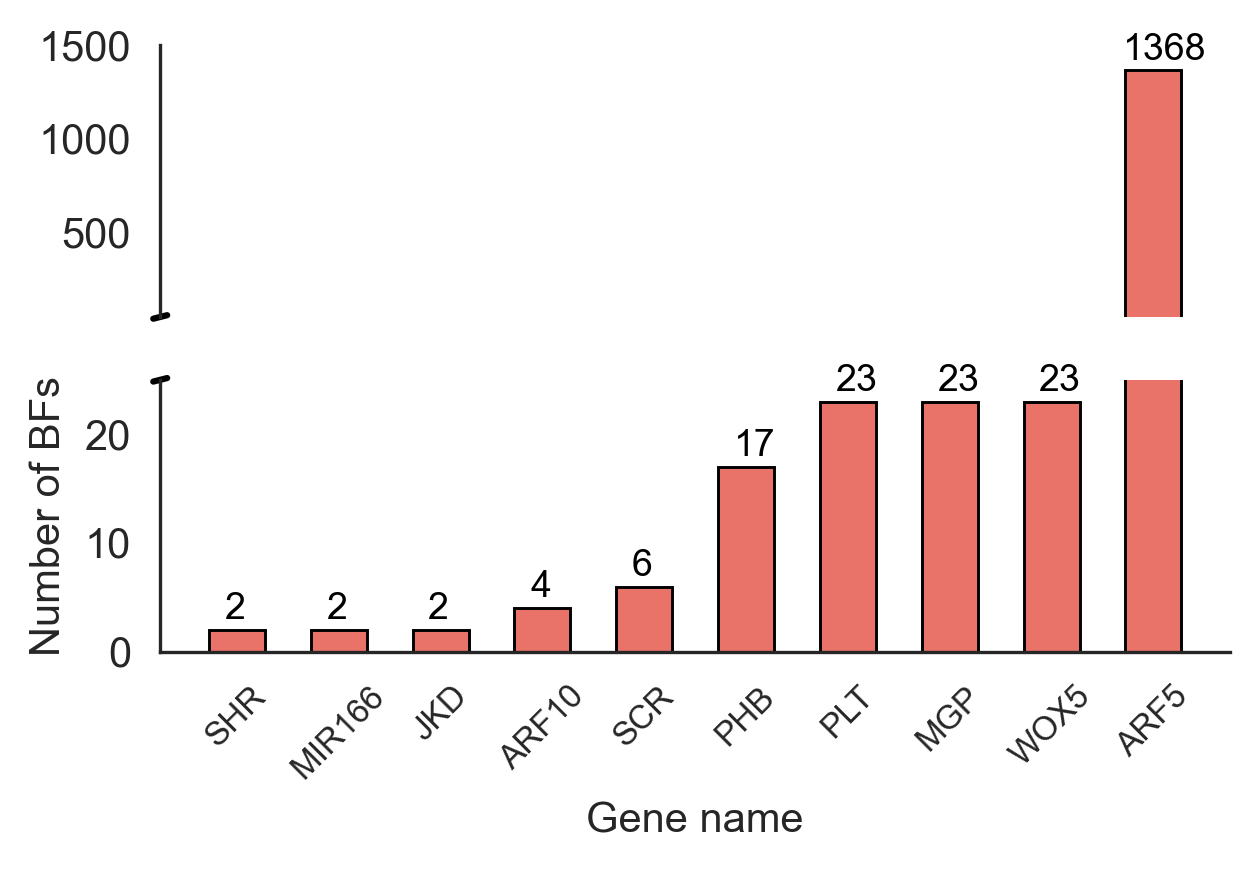

In [21]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in Boolean Gene Regulatory Networks
'''
#------------------------------------------------------------------------------------------------------------------
# Distribution of BFs at each node of the RSCN 2020 model after imposing fixed point and sc-NCF constraints on 
# their truth tables 
#------------------------------------------------------------------------------------------------------------------
dpi = 300
mpl.rcParams['figure.dpi']= dpi

with open ('../data/buylla_RSCN_2020/gene_BF_dict.pkl', 'rb') as file:
    gene_BF_dict = pkl.load(file)
with open ('../data/buylla_RSCN_2020/node_num.pkl', 'rb') as file:
    node_num = pkl.load(file)

len_gene_BF_dict = {ele:len(gene_BF_dict[ele]) for ele in gene_BF_dict}
gene_BF_dict_ord = {}
for k, v in sorted(len_gene_BF_dict.items(), key=lambda item:item[1]):
    if v!=1:
        gene_BF_dict_ord[k] = gene_BF_dict[k]

num_node = {node_num[node]:node for node in node_num}

nodes = []
freq  = []
for num in gene_BF_dict_ord:
    nodes += [num_node[num]]
    freq += [len(gene_BF_dict_ord[num])]

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches (4.3, 3)

# plot the same data on both axes
ax.bar(nodes, freq, color = '#EA7369', width = 0.55, align='center', linewidth=0.7,  edgecolor='black')
ax2.bar(nodes, freq, color = '#EA7369', width = 0.55, align='center', linewidth=0.7,  edgecolor='black')
ax2.xaxis.set_ticks(list(range(len(gene_BF_dict_ord)))) #Added here to remove warning; does not appear while using savefig
ax2.set_xticklabels(nodes, size = 8, rotation= 45)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(50, 1500)  # outliers
ax2.set_ylim(0, 25)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(False)

#ax.xaxis.tick_top()  # don't put tick labels at the top
#ax2.xaxis.tick_bottom()

#label the axes
ax2.set_xlabel ('Gene name')
ax2.set_ylabel ('Number of BFs')
ax.xaxis.set_ticks_position('none') 
#ax.tick_params(labelbottom='off')
#ax.set_xticks([])
#ax2.xaxis.tick_bottom('False')

# Place text over bars
for i in range(len(nodes)):
    if i != len(nodes) - 1:
        ax2.text(i-0.12, freq[i]+1 , str(freq[i]), color='black', size= 9)
    else:
        ax.text(i-0.3, freq[i]+ 50 , str(freq[i]), color='black', size= 9)

d = .0065  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
#ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
#ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
plt.tight_layout()
#plt.savefig ('../../results/final_figures/freq_distr4.pdf')
plt.show()


In [22]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in Boolean Gene Regulatory Networks
'''
#------------------------------------------------------------------------------------------------------------------
# Gives the pairwise hierarchies for the fixed points using the stochastic method to compute the MFPT
#------------------------------------------------------------------------------------------------------------------

def get_hierarchies_MFPT (fxd_pt_pair_list, bio_fxd_pts, noise, trajectory, stv):
    '''
    pair_wise_list : [('FP1', 'FP2'), ('FP2, FP3')]
    bio_fxd_pts : dicrionary of biological fixed points
    noise : value of noise as decimal
    trajectory : number of trajectories to run
    stv : state transition vector
    '''
    hierarchy = []
    for fxd_pt_pair in fxd_pt_pair_list:
        M01 = RS.MFPT_num_2_states (bio_fxd_pts[fxd_pt_pair[0]], bio_fxd_pts[fxd_pt_pair[1]], noise, trajectory, stv)
        M10 = RS.MFPT_num_2_states (bio_fxd_pts[fxd_pt_pair[1]], bio_fxd_pts[fxd_pt_pair[0]], noise, trajectory, stv)
        mf01, er01 = M01['mfpt'], M01['sterr']
        mf10, er10 = M10['mfpt'], M10['sterr']
        
        if (mf01 + er01 > mf10 - er10) and (mf01 + er01 < mf10 + er10):
            hierarchy += [fxd_pt_pair[0] + ' X ' + fxd_pt_pair[1]]
            
        elif (mf01 - er01 > mf10 - er10) and (mf01 + er01 < mf10 + er10):
            hierarchy += [fxd_pt_pair[0] + ' X ' + fxd_pt_pair[1]]
            
        elif (mf10 + er10 > mf01 - er01) and (mf10 + er10 < mf01 + er01):
            hierarchy += [fxd_pt_pair[0] + ' X ' + fxd_pt_pair[1]]

        elif (mf10 - er10 > mf01 - er01) and (mf10 + er10 < mf01 + er01):
            hierarchy += [fxd_pt_pair[0] + ' X ' + fxd_pt_pair[1]]

        else:
            if mf01 > mf10:
                hierarchy += [fxd_pt_pair[0] + ' < ' + fxd_pt_pair[1]]
                             
            elif mf01 < mf10:
                hierarchy += [fxd_pt_pair[0] + ' > ' + fxd_pt_pair[1]]

    return hierarchy

In [32]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in Boolean Gene Regulatory Networks
'''
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Setup for running the iterative greedy algorithm
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Obtain an ordered dictionary of the genes based on the number of possible BFs at each gene from file
with open ('../data/buylla_RSCN_2020/gene_BF_dict.pkl', 'rb') as file:
    gene_BF_dict = pkl.load(file)
len_gene_BF_dict = {ele:len(gene_BF_dict[ele]) for ele in gene_BF_dict}
gene_BF_dict_ord = {}
for k, v in sorted(len_gene_BF_dict.items(), key=lambda item:item[1]):
    if v != 1 :
        gene_BF_dict_ord[k] = gene_BF_dict[k]

gene_BF_dict = gene_BF_dict_ord

#Boolean model proposed in Buylla RSCN 2020
with open ('../data/buylla_RSCN_2020/org_BF_list.pkl', 'rb') as file:
    current_BFlist = pkl.load(file)
with open ('../data/buylla_RSCN_2020/inedges.pkl', 'rb') as file:
    inedges = pkl.load(file)

#Obtain a dictionary of the biologically relevant fixed points from file
attr_table = pd.read_csv('../data/buylla_RSCN_2020/attractors_buylla_RSCN_2020.tsv', sep = '\t')
attr_table = attr_table.drop(['gene'], axis = 1).T
bio_fxd_pts_ints = BN.BitsToIntsFast (np.array(attr_table))
bio_fxd_pts = {attr_table.index[i]:bio_fxd_pts_ints[i] for i in range(len(bio_fxd_pts_ints))}

#List of pair for which qualitative hierarchy is available:
with open ('../data/buylla_RSCN_2020/expected_hierarchy_buylla_RSCN_2020.txt') as file:
    expec_hier = []
    pair_list = []
    for line in file:
        l = line.strip('\n')
        expec_hier += [l]
        pair_list += [l.split (' < ')]

all_states = BN.IntsToBitsFast(np.arange(2**len(inedges)), len(inedges))
current_bn = np.zeros([2**len(inedges), len(inedges)], dtype = int)
for gene in inedges:
    q = inedges[gene]
    ind = BN.BitsToIntsFast(all_states[:,q])
    f = BN.IntsToBitsFast_large(current_BFlist[gene], 2**len(q))
    current_bn[:,gene] = f[:,ind]

# Parameters for MFPT
noise = 0.05
trajectories = 2500

current_stv = BN.BitsToIntsFast(current_bn)    #stv: state transition vector
current_hierarchy = get_hierarchies_MFPT(pair_list, bio_fxd_pts, noise, trajectories, current_stv)
stg_current = nx.DiGraph()                  #stg: state transition graph
stg_current.add_edges_from (list(zip(np.arange(len(current_stv)), current_stv)))

#Compute the basin sizes of the biologically relevant fixed points
current_bn_basin_sizes = {}
for fxd_pt in bio_fxd_pts:
    current_bn_basin_sizes[fxd_pt] = len(nx.ancestors(stg_current, bio_fxd_pts[fxd_pt])) + 1


#Note: Since we are computing the total basin fraction occupied by within while fixing AUX = 1, 
#we divide the below expresion by len(inedges)-1 instead of len(inedges)
min_basin_size_frac = sum(current_bn_basin_sizes.values())/2**(len(inedges)-1)  #This value is used as the threshold

org_BFlist = current_BFlist.copy()
org_basin_sizes = current_bn_basin_sizes.copy()
org_hierarchy = current_hierarchy.copy()
org_bn = np.copy(current_bn)
print ('Hierarchies of the RSCN 2020 model using MFPT:\n', org_hierarchy)
print ('\nExpected hierarchy according to biological landscape:\n', expec_hier)

Hierarchies of the RSCN 2020 model using MFPT:
 ['QC > CEI/EndodermisPD', 'QC < P.ProvascularPD', 'QC < C.ProvascularPD', 'QC < C.ProvascularTD2', 'QC < Columella1', 'C.ProvascularPD < C.ProvascularTD2']

Expected hierarchy according to biological landscape:
 ['QC < CEI/EndodermisPD', 'QC < P.ProvascularPD', 'QC < C.ProvascularPD', 'QC < C.ProvascularTD2', 'QC < Columella1', 'C.ProvascularPD < C.ProvascularTD2']


In [33]:
'''
Written by Ajay Subbaroyan
A. Subbaroyan, P. Sil, O.C. Martin* & A. Samal*, Leveraging Developmental Landscapes for Model Selection in Boolean Gene Regulatory Networks
'''
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Iterative greedy algorithm starting from the RSCN 2020 model
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
i = 0
while True:
    for gene in gene_BF_dict:
        next_bf_int = random.choice(gene_BF_dict[gene]) #Randomly choose the next BF

        #Obtain the state transition graph of the Boolean network
        gene_inps = inedges[gene] 
        ind = BN.BitsToIntsFast(all_states[:,gene_inps])
        next_bf_vec = BN.IntsToBitsFast_large(next_bf_int, 2**len(gene_inps))
        next_bn = np.copy(current_bn)
        next_bn[:,gene] = next_bf_vec[:,ind]
        next_stv = BN.BitsToIntsFast(next_bn)       #stv: state transition vector
        next_stg = nx.DiGraph()                     #stg: state transition graph
        next_stg.add_edges_from (list(zip(np.arange(len(next_stv)), next_stv)))
        next_bn_basin_sizes = {}

        for fxd_pt in bio_fxd_pts:
            next_bn_basin_sizes[fxd_pt] = len(nx.ancestors(next_stg, bio_fxd_pts[fxd_pt])) + 1

        i += 1
        if sum(next_bn_basin_sizes.values())/2**(len(inedges)-1) < min_basin_size_frac: #go to next gene if next_bf_int shrinks the basin size occupied by the biological fixed points
            x = 'Worse by cumulative basin size'
            print (x)
            continue

        else:
            #Compute the relevant MFPTs for the biologically relevant fixed points
            next_hierarchy = get_hierarchies_MFPT (pair_list, bio_fxd_pts, noise, trajectories, next_stv)
            exp_curr_overlap = set(expec_hier).intersection (set(current_hierarchy))
            exp_next_overlap = set(expec_hier).intersection (set(next_hierarchy))

            if len(exp_next_overlap) == len(expec_hier):
                current_BFlist[gene] = next_bf_int
                with open ('../data/buylla_RSCN_2020/RSCN2020_best_models.txt', 'a+') as file:
                    file.write(str(current_BFlist) + '\t' + str(i)+ "\n")

                x = 'Best by hierarchy'
                print (x)
                break

            elif len(exp_next_overlap) > len (exp_curr_overlap):                    
                current_BFlist[gene] = next_bf_int
                current_bn = next_bn
                current_bn_basin_sizes = next_bn_basin_sizes
                current_hierarchy = next_hierarchy

                x = 'Better by hierarchy'
                print (x)

            elif len(exp_next_overlap) == len (exp_curr_overlap):
                current_BFlist[gene] = next_bf_int
                current_bn = next_bn
                current_bn_basin_sizes = next_bn_basin_sizes
                current_hierarchy = next_hierarchy

                x = 'Equivalent by hierarchy'
                print (x)

            elif len(exp_next_overlap) < len(exp_curr_overlap):

                x = 'Worse by hierarchy'
                print (x)

        if x == 'Best by hierarchy':
            break

    if x == 'Best by hierarchy':
        break

print ('Number of iterations taken to reach model: ', i) # Number of iterations taken to reach a model that satisfies the expected hierarchies
bf_list = current_BFlist

Equivalent by hierarchy
Equivalent by hierarchy
Equivalent by hierarchy
Worse by hierarchy
Equivalent by hierarchy
Worse by hierarchy
Worse by hierarchy
Equivalent by hierarchy
Equivalent by hierarchy
Worse by cumulative basin size
Worse by cumulative basin size
Equivalent by hierarchy
Equivalent by hierarchy
Equivalent by hierarchy
Worse by hierarchy
Worse by hierarchy
Equivalent by hierarchy
Worse by cumulative basin size
Equivalent by hierarchy
Equivalent by hierarchy
Equivalent by hierarchy
Equivalent by hierarchy
Worse by hierarchy
Equivalent by hierarchy
Worse by hierarchy
Worse by hierarchy
Worse by cumulative basin size
Worse by cumulative basin size
Worse by hierarchy
Equivalent by hierarchy
Worse by hierarchy
Equivalent by hierarchy
Equivalent by hierarchy
Equivalent by hierarchy
Worse by hierarchy
Worse by cumulative basin size
Equivalent by hierarchy
Worse by cumulative basin size
Equivalent by hierarchy
Equivalent by hierarchy
Equivalent by hierarchy
Equivalent by hierarch

In [34]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Test to check whether the recovered model indeed satisfies the expected hierarchies
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
alt_model2020 = RS(inedges, bf_list, bio_fxd_pts_ints)
stv = alt_model2020.STV()
fps = alt_model2020.fxd_pts(stv)
bsz = alt_model2020.basin_sizes_fps(stv)
boa = {fp:alt_model2020.basin_fp(fp, stv) for fp in bio_fxd_pts_ints}
print ('Fraction of basin sizes of all biological attractors (among AUX = 1 states):\n', sum(bsz.values())/2**(len(inedges)-1))
bio_fxd_pts_rev = {bio_fxd_pts[ele]:ele for ele in bio_fxd_pts}
print ('\nExpected hierarchy according to biological landscape:\n', expec_hier)
print ('\nHierarchy according to basin size:\n', {bio_fxd_pts_rev[fp]:bsz[fp] for fp in bsz})
print ('\nHierarchy according to MFPT:\n', get_hierarchies_MFPT (pair_list, bio_fxd_pts, noise, trajectories, stv))

Fraction of basin sizes of all biological attractors (among AUX = 1 states):
 0.933837890625

Expected hierarchy according to biological landscape:
 ['QC < CEI/EndodermisPD', 'QC < P.ProvascularPD', 'QC < C.ProvascularPD', 'QC < C.ProvascularTD2', 'QC < Columella1', 'C.ProvascularPD < C.ProvascularTD2']

Hierarchy according to basin size:
 {'QC': 2560, 'C.ProvascularPD': 10240, 'C.ProvascularTD2': 10240, 'CEI/EndodermisPD': 13824, 'Columella1': 38912, 'P.ProvascularPD': 46624}

Hierarchy according to MFPT:
 ['QC < CEI/EndodermisPD', 'QC < P.ProvascularPD', 'QC < C.ProvascularPD', 'QC < C.ProvascularTD2', 'QC < Columella1', 'C.ProvascularPD < C.ProvascularTD2']
